# Análise de Artigos Científicos com Gemini AI

## Escopo: Nanorevestimentos e Tintas (Nanocoatings and Paints)

Este notebook realiza análise automatizada de artigos científicos para identificar trabalhos relevantes ao escopo de nanorevestimentos e tintas usando a API do Google Gemini.

### Funcionalidades:
1. **Instalação de dependências**
2. **Configuração da API Gemini**
3. **Definição de palavras-chave específicas**
4. **Busca e filtro de artigos**
5. **Análise individual de abstracts**
6. **Processamento em lote com rate limiting**
7. **Sistema de checkpoint para recuperação**




In [22]:
# Instalação das dependências necessárias
!pip install google-generativeai pandas

In [23]:
# Imports necessários
import pandas as pd
import google.generativeai as genai
import time
import random
import os
from typing import List, Optional

# Função para carregar API key do arquivo
def carregar_api_key(arquivo_api='api_key.txt'):
    """
    Carrega a API key do arquivo especificado
    
    Args:
        arquivo_api: Caminho para o arquivo contendo a API key
    
    Returns:
        String com a API key ou None se houver erro
    """
    try:
        # Verificar se o arquivo existe
        if not os.path.exists(arquivo_api):
            print(f"❌ Arquivo '{arquivo_api}' não encontrado!")
            print(f"💡 Crie o arquivo '{arquivo_api}' e coloque sua API key nele")
            return None
        
        # Ler a API key do arquivo
        with open(arquivo_api, 'r', encoding='utf-8') as file:
            api_key = file.read().strip()
        
        # Verificar se a API key não está vazia
        if not api_key:
            print(f"❌ Arquivo '{arquivo_api}' está vazio!")
            return None
        
        # Verificar formato básico da API key (deve começar com 'AIza')
        if not api_key.startswith('AIza'):
            print(f"⚠️ API key pode estar no formato incorreto")
            print(f"   APIs do Google Gemini geralmente começam com 'AIza'")
        
        print(f"✅ API key carregada com sucesso de '{arquivo_api}'")
        print(f"🔑 API key: {api_key[:10]}...{api_key[-4:]} (ocultada por segurança)")
        
        return api_key
        
    except FileNotFoundError:
        print(f"❌ Arquivo '{arquivo_api}' não encontrado!")
        print(f"💡 Crie o arquivo '{arquivo_api}' e coloque sua API key nele")
        return None
    except PermissionError:
        print(f"❌ Sem permissão para ler o arquivo '{arquivo_api}'")
        return None
    except Exception as e:
        print(f"❌ Erro ao carregar API key: {e}")
        return None

# Carregar e configurar a API do Gemini
print("🔐 Carregando configurações da API...")

api_key = carregar_api_key('api_key.txt')

if api_key:
    # Configurar a API do Gemini
    genai.configure(api_key=api_key)
    print("✅ API do Gemini configurada com sucesso")
    
    # Testar a conexão (opcional)
    try:
        # Fazer um teste simples para verificar se a API está funcionando
        model = genai.GenerativeModel('gemini-2.0-flash-exp')
        test_response = model.generate_content("Hello")
        print("🔗 Conexão com a API testada com sucesso")
    except Exception as e:
        print(f"⚠️ Erro ao testar a API: {e}")
        print("   A API key pode estar inválida ou sem créditos")
        
else:
    print("❌ Não foi possível configurar a API")
    print("\n📋 Para configurar a API:")
    print("1. Crie um arquivo chamado 'api_key.txt' no mesmo diretório deste notebook")
    print("2. Cole sua API key do Google Gemini no arquivo (apenas a key, sem aspas)")
    print("3. Salve o arquivo e execute novamente esta célula")
    print("\n🔗 Como obter uma API key:")
    print("   Acesse: https://makersuite.google.com/app/apikey")

print("\n✅ Dependências carregadas")

🔐 Carregando configurações da API...
❌ Arquivo 'api_key.txt' não encontrado!
💡 Crie o arquivo 'api_key.txt' e coloque sua API key nele
❌ Não foi possível configurar a API

📋 Para configurar a API:
1. Crie um arquivo chamado 'api_key.txt' no mesmo diretório deste notebook
2. Cole sua API key do Google Gemini no arquivo (apenas a key, sem aspas)
3. Salve o arquivo e execute novamente esta célula

🔗 Como obter uma API key:
   Acesse: https://makersuite.google.com/app/apikey

✅ Dependências carregadas


In [24]:
# Criar arquivo .gitignore para proteger a API key
def criar_gitignore():
    """
    Cria ou atualiza arquivo .gitignore para proteger arquivos sensíveis
    """
    gitignore_content = """# API Keys e arquivos sensíveis
api_key.txt
*.key
.env

# Arquivos de checkpoint
*checkpoint*.csv

# Arquivos temporários
*.tmp
*.temp

# Resultados de análises (opcional - remova se quiser versionar)
*_resultado.csv
*_analise.csv
nanomateriais_identificados*.csv

# Jupyter Notebook checkpoints
.ipynb_checkpoints/

# Python cache
__pycache__/
*.pyc
*.pyo
"""
    
    try:
        with open('.gitignore', 'w', encoding='utf-8') as file:
            file.write(gitignore_content)
        print("✅ Arquivo .gitignore criado/atualizado com sucesso")
        print("🔒 Seus arquivos sensíveis estão protegidos do versionamento")
    except Exception as e:
        print(f"⚠️ Erro ao criar .gitignore: {e}")

# Executar a criação do .gitignore
criar_gitignore()

# Função auxiliar para criar arquivo de exemplo da API key
def criar_exemplo_api_key():
    """
    Cria um arquivo de exemplo mostrando como configurar a API key
    """
    exemplo_content = """AIzaSyA_exemplo_da_sua_api_key_aqui_substitua_por_sua_key_real

INSTRUÇÕES:
1. Substitua o texto acima pela sua API key real do Google Gemini
2. Mantenha apenas a API key (sem aspas, sem espaços extras)
3. Salve este arquivo como 'api_key.txt'
4. Delete esta linha de instruções

Como obter sua API key:
- Acesse: https://makersuite.google.com/app/apikey
- Faça login com sua conta Google
- Clique em "Create API Key"
- Copie a key gerada e cole aqui
"""
    
    try:
        if not os.path.exists('api_key.txt'):
            with open('api_key_exemplo.txt', 'w', encoding='utf-8') as file:
                file.write(exemplo_content)
            print("📝 Arquivo 'api_key_exemplo.txt' criado")
            print("   Renomeie para 'api_key.txt' e adicione sua key real")
    except Exception as e:
        print(f"⚠️ Erro ao criar exemplo: {e}")

# Criar exemplo se não existir api_key.txt
if not os.path.exists('api_key.txt'):
    print("\n📝 API key não encontrada. Criando arquivo de exemplo...")
    criar_exemplo_api_key()

✅ Arquivo .gitignore criado/atualizado com sucesso
🔒 Seus arquivos sensíveis estão protegidos do versionamento

📝 API key não encontrada. Criando arquivo de exemplo...
📝 Arquivo 'api_key_exemplo.txt' criado
   Renomeie para 'api_key.txt' e adicione sua key real


## 1. Configuração de Parâmetros

Definição dos parâmetros principais para análise e rate limiting da API.

In [25]:
# Configurações principais
CONFIG = {
    'modelo_gemini': 'gemini-2.0-flash-exp',  # Flash-Lite para rate limits melhores
    'max_requests_per_minute': 20,              # Limite de requisições por minuto
    'max_requests_per_day': 1000,               # Limite diário recomendado
    'delay_between_requests': 5,              # Delay entre requisições (segundos)
    'arquivo_entrada': '/home/delon/Modelos/cenanoink/Projeto-CENanoInk/Alan Delon.csv',
    'checkpoint_file': 'analise_escopo_checkpoint.csv',
    'arquivo_saida': 'df_com_analise_escopo_completo.csv'
}

print("📋 Configurações carregadas:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

📋 Configurações carregadas:
  modelo_gemini: gemini-2.0-flash-exp
  max_requests_per_minute: 20
  max_requests_per_day: 1000
  delay_between_requests: 5
  arquivo_entrada: /home/delon/Modelos/cenanoink/Projeto-CENanoInk/Alan Delon.csv
  checkpoint_file: analise_escopo_checkpoint.csv
  arquivo_saida: df_com_analise_escopo_completo.csv


In [ ]:

# VERSÃO OTIMIZADA - Identificação de Nanomateriais
import pandas as pd
import google.generativeai as genai
import time
import re
from collections import Counter
from typing import Set, Dict, List

# Configuração otimizada
CONFIG_OTIMIZADO = {
    'modelo_gemini': 'gemini-2.0-flash-exp',
    'max_requests_per_minute': 25,
    'delay_between_requests': 2.5,
    'batch_size': 50,  # Processar em lotes maiores
    'verbose': False   # Reduzir verbosidade
}

# Nanomateriais organizados e otimizados
NANOMATERIAIS_OTIMIZADO = {
    'oxidos_metalicos': [
        'TiO2', 'titanium dioxide', 'ZnO', 'zinc oxide',
        'Al2O3', 'alumina', 'SiO2', 'silica', 'Fe2O3', 'iron oxide',
        'CeO2', 'cerium oxide', 'SnO2', 'tin oxide'
    ],
    'nanoparticulas_metalicas': [
        'silver nanoparticle', 'AgNP', 'gold nanoparticle', 'AuNP',
        'copper nanoparticle', 'CuNP', 'iron nanoparticle', 'FeNP'
    ],
    'nanomateriais_carbono': [
        'carbon nanotube', 'CNT', 'graphene', 'graphene oxide',
        'fullerene', 'carbon black', 'carbon nanofiber'
    ],
    'outros': [
        'quantum dot', 'nanoclay', 'nanocellulose', 'polymer nanocomposite'
    ]
}

def criar_patterns_regex() -> Dict[str, re.Pattern]:
    """Cria patterns regex otimizados para busca rápida"""
    patterns = {}
    for categoria, materiais in NANOMATERIAIS_OTIMIZADO.items():
        # Criar pattern regex case-insensitive
        pattern_str = '|'.join(re.escape(mat) for mat in materiais)
        patterns[categoria] = re.compile(f'({pattern_str})', re.IGNORECASE)
    return patterns

def identificar_nanomateriais_rapido(abstract_text: str, patterns: Dict[str, re.Pattern]) -> Set[str]:
    """Identificação rápida usando regex - sem Gemini"""
    if pd.isna(abstract_text) or not str(abstract_text).strip():
        return set()
    
    materiais_encontrados = set()
    text = str(abstract_text)
    
    for categoria, pattern in patterns.items():
        matches = pattern.findall(text)
        materiais_encontrados.update(matches)
    
    return materiais_encontrados

def identificar_nanomateriais_gemini_batch(abstracts: List[str]) -> List[str]:
    """Processamento em lote com Gemini para maior eficiência"""
    if not abstracts:
        return []
    
    # Combinar múltiplos abstracts em uma única requisição
    combined_text = "\n\n---ABSTRACT---\n\n".join(abstracts[:5])  # Máximo 5 por requisição
    
    model = genai.GenerativeModel(CONFIG_OTIMIZADO['modelo_gemini'])
    
    prompt = f"""
    Analise os abstracts científicos separados por "---ABSTRACT---" e identifique nanomateriais em cada um.
    
    {combined_text}
    
    Para cada abstract, liste os nanomateriais encontrados ou "NENHUM" se não houver.
    Formato de resposta:
    ABSTRACT 1: material1, material2
    ABSTRACT 2: NENHUM
    ABSTRACT 3: material3
    
    Use nomenclatura padrão (TiO2, ZnO, graphene, etc.)
    """
    
    try:
        response = model.generate_content(prompt)
        return processar_resposta_batch(response.text, len(abstracts[:5]))
    except Exception as e:
        print(f"Erro Gemini batch: {e}")
        return ["Erro"] * len(abstracts[:5])

def processar_resposta_batch(response_text: str, num_abstracts: int) -> List[str]:
    """Processa resposta em lote do Gemini"""
    linhas = response_text.strip().split('\n')
    resultados = []
    
    for i in range(num_abstracts):
        encontrado = False
        for linha in linhas:
            if f"ABSTRACT {i+1}:" in linha:
                material_part = linha.split(':', 1)[1].strip()
                if material_part.upper() == "NENHUM":
                    resultados.append("Nenhum nanomaterial identificado")
                else:
                    resultados.append(material_part)
                encontrado = True
                break
        
        if not encontrado:
            resultados.append("Nenhum nanomaterial identificado")
    
    return resultados

def processar_dataframe_otimizado(df: pd.DataFrame, 
                                use_gemini: bool = False,
                                max_linhas: int = None) -> pd.DataFrame:
    """Versão otimizada do processamento"""
    
    if 'Abstract' not in df.columns:
        print("❌ Coluna 'Abstract' não encontrada")
        return df
    
    # Limitar processamento se especificado
    if max_linhas:
        df_work = df.head(max_linhas).copy()
    else:
        df_work = df.copy()
    
    print(f"🚀 Processando {len(df_work)} abstracts (modo otimizado)")
    
    # Criar patterns regex uma vez
    patterns = criar_patterns_regex()
    
    # Inicializar coluna
    df_work['Nanomaterial Citado'] = ''
    
    # FASE 1: Busca rápida com regex (todos os abstracts)
    print("📍 Fase 1: Busca rápida por palavras-chave...")
    start_time = time.time()
    
    for idx in range(len(df_work)):
        abstract = df_work.iloc[idx]['Abstract']
        materiais = identificar_nanomateriais_rapido(abstract, patterns)
        
        if materiais:
            resultado = ', '.join(sorted(materiais))
        else:
            resultado = "Nenhum nanomaterial identificado"
        
        df_work.iloc[idx, df_work.columns.get_loc('Nanomaterial Citado')] = resultado
        
        # Progresso a cada 100 linhas
        if (idx + 1) % 100 == 0:
            print(f"  Processado: {idx + 1}/{len(df_work)}")
    
    fase1_time = time.time() - start_time
    print(f"✅ Fase 1 concluída em {fase1_time:.1f}s")
    
    # FASE 2: Gemini apenas para abstracts sem nanomateriais (opcional)
    if use_gemini:
        abstracts_sem_materiais = df_work[
            df_work['Nanomaterial Citado'] == "Nenhum nanomaterial identificado"
        ]
        
        if len(abstracts_sem_materiais) > 0:
            print(f"📍 Fase 2: Análise Gemini para {len(abstracts_sem_materiais)} abstracts sem materiais...")
            
            abstracts_list = abstracts_sem_materiais['Abstract'].tolist()
            indices_list = abstracts_sem_materiais.index.tolist()
            
            # Processar em lotes
            for i in range(0, len(abstracts_list), 5):
                batch_abstracts = abstracts_list[i:i+5]
                batch_indices = indices_list[i:i+5]
                
                resultados = identificar_nanomateriais_gemini_batch(batch_abstracts)
                
                # Atualizar DataFrame
                for idx, resultado in zip(batch_indices, resultados):
                    df_work.iloc[
                        df_work.index.get_loc(idx), 
                        df_work.columns.get_loc('Nanomaterial Citado')
                    ] = resultado
                
                # Rate limiting
                time.sleep(CONFIG_OTIMIZADO['delay_between_requests'])
                
                if (i + 5) % 25 == 0:
                    print(f"  Gemini: {min(i + 5, len(abstracts_list))}/{len(abstracts_list)}")
    
    return df_work

def gerar_estatisticas_rapidas(df: pd.DataFrame) -> None:
    """Gera estatísticas de forma otimizada"""
    if 'Nanomaterial Citado' not in df.columns:
        print("❌ Coluna não encontrada")
        return
    
    # Contar materiais
    todos_materiais = []
    for materiais_str in df['Nanomaterial Citado'].dropna():
        if materiais_str and "nenhum" not in materiais_str.lower() and "erro" not in materiais_str.lower():
            materiais = [m.strip() for m in materiais_str.split(',')]
            todos_materiais.extend(materiais)
    
    contador = Counter(todos_materiais)
    
    print(f"\n📊 ESTATÍSTICAS RÁPIDAS")
    print(f"Total de artigos: {len(df):,}")
    print(f"Artigos com nanomateriais: {len(df[df['Nanomaterial Citado'] != 'Nenhum nanomaterial identificado']):,}")
    print(f"Materiais únicos identificados: {len(contador)}")
    
    if contador:
        print(f"\n🏆 Top 5 nanomateriais:")
        for i, (material, count) in enumerate(contador.most_common(5), 1):
            print(f"  {i}. {material}: {count} menções")

# EXECUÇÃO OTIMIZADA
print("🚀 VERSÃO OTIMIZADA - IDENTIFICAÇÃO DE NANOMATERIAIS")
print("="*60)

# Carregar dados
try:
    df = pd.read_csv(CONFIG['arquivo_entrada'])
    print(f"✅ {len(df):,} artigos carregados")
    
    if 'Abstract' in df.columns:
        abstracts_validos = df['Abstract'].notna().sum()
        print(f"📄 {abstracts_validos:,} abstracts disponíveis")
        
        # Opções de processamento
        print("\nOpções:")
        print("1. Apenas busca rápida (regex) - Recomendado")
        print("2. Busca rápida + Gemini para casos não identificados")
        print("3. Teste com 50 abstracts")
        
        opcao = input("Escolha (1/2/3): ")
        
        if opcao == "3":
            # Teste rápido
            print("\n🧪 TESTE RÁPIDO (50 abstracts)")
            df_result = processar_dataframe_otimizado(df, use_gemini=False, max_linhas=50)
            gerar_estatisticas_rapidas(df_result)
            
        elif opcao == "1":
            # Processamento rápido completo
            print("\n🚀 PROCESSAMENTO COMPLETO (só regex)")
            df_result = processar_dataframe_otimizado(df, use_gemini=False)
            
            # Salvar
            arquivo_saida = 'nanomateriais_identificados_rapido.csv'
            df_result.to_csv(arquivo_saida, index=False)
            print(f"💾 Salvo em: {arquivo_saida}")
            
            gerar_estatisticas_rapidas(df_result)
            
        elif opcao == "2":
            # Processamento híbrido
            print("\n🤖 PROCESSAMENTO HÍBRIDO (regex + Gemini)")
            df_result = processar_dataframe_otimizado(df, use_gemini=True)
            
            # Salvar
            arquivo_saida = 'nanomateriais_identificados_hibrido.csv'
            df_result.to_csv(arquivo_saida, index=False)
            print(f"💾 Salvo em: {arquivo_saida}")
            
            gerar_estatisticas_rapidas(df_result)
    
    else:
        print("❌ Coluna 'Abstract' não encontrada")
        
except Exception as e:
    print(f"❌ Erro: {e}")

🚀 VERSÃO OTIMIZADA - IDENTIFICAÇÃO DE NANOMATERIAIS
✅ 525 artigos carregados
📄 525 abstracts disponíveis

Opções:
1. Apenas busca rápida (regex) - Recomendado
2. Busca rápida + Gemini para casos não identificados
3. Teste com 50 abstracts

🚀 PROCESSAMENTO COMPLETO (só regex)
🚀 Processando 525 abstracts (modo otimizado)
📍 Fase 1: Busca rápida por palavras-chave...
  Processado: 100/525
  Processado: 200/525
  Processado: 300/525
  Processado: 400/525
  Processado: 500/525
✅ Fase 1 concluída em 0.7s
💾 Salvo em: nanomateriais_identificados_rapido.csv

📊 ESTATÍSTICAS RÁPIDAS
Total de artigos: 525
Artigos com nanomateriais: 179
Materiais únicos identificados: 39

🏆 Top 5 nanomateriais:
  1. TiO2: 42 menções
  2. ZnO: 25 menções
  3. Al2O3: 24 menções
  4. carbon nanotube: 20 menções
  5. alumina: 19 menções


✅ Bibliotecas de visualização carregadas
✅ Bibliotecas de ML carregadas
✅ NetworkX carregado
✅ WordCloud carregado
🚀 ANÁLISE ULTRA ROBUSTA DE NANOMATERIAIS (VERSÃO CORRIGIDA)
✅ Analisador inicializado com sucesso
✅ 525 artigos carregados
📄 525 abstracts disponíveis

🎯 OPÇÕES DE ANÁLISE:
1. Análise completa (regex + AI + visualizações + relatório)
2. Análise rápida (só regex + estatísticas)
3. Teste com amostra (50 abstracts)
4. Análise personalizada

🔥 ANÁLISE COMPLETA
🚀 ANÁLISE ULTRA ROBUSTA - 525 abstracts
📍 FASE 1: Extração rápida com patterns avançados...
  ✓ Processado: 100/525
  ✓ Processado: 200/525
  ✓ Processado: 300/525
  ✓ Processado: 400/525
  ✓ Processado: 500/525
✅ Fase 1 concluída em 4.9s

📍 FASE 2: Análise AI para 50 abstracts selecionados...
Erro Gemini: 429 You exceeded your current quota. Please migrate to Gemini 2.0 Flash Preview (Image Generation) (models/gemini-2.0-flash-preview-image-generation) for higher quota limits. For more information on this error, head to

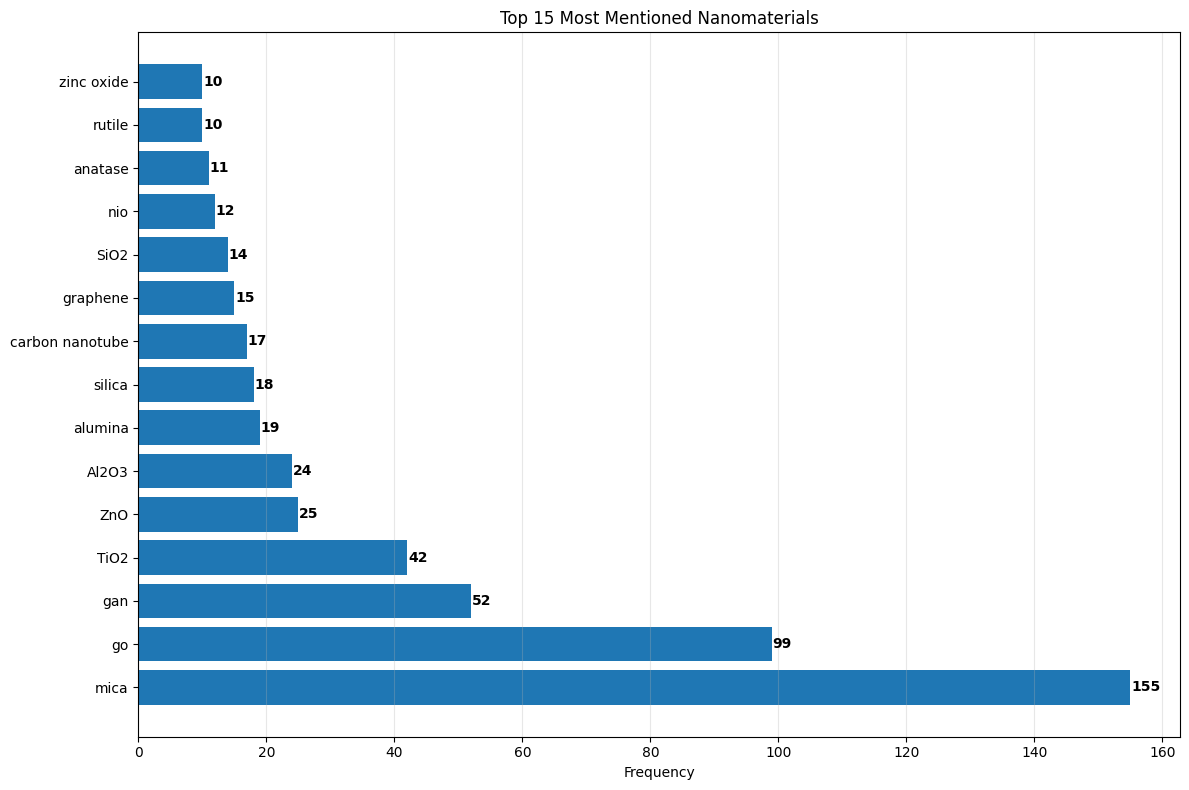

✅ Gráfico de distribuição de nanomateriais criado


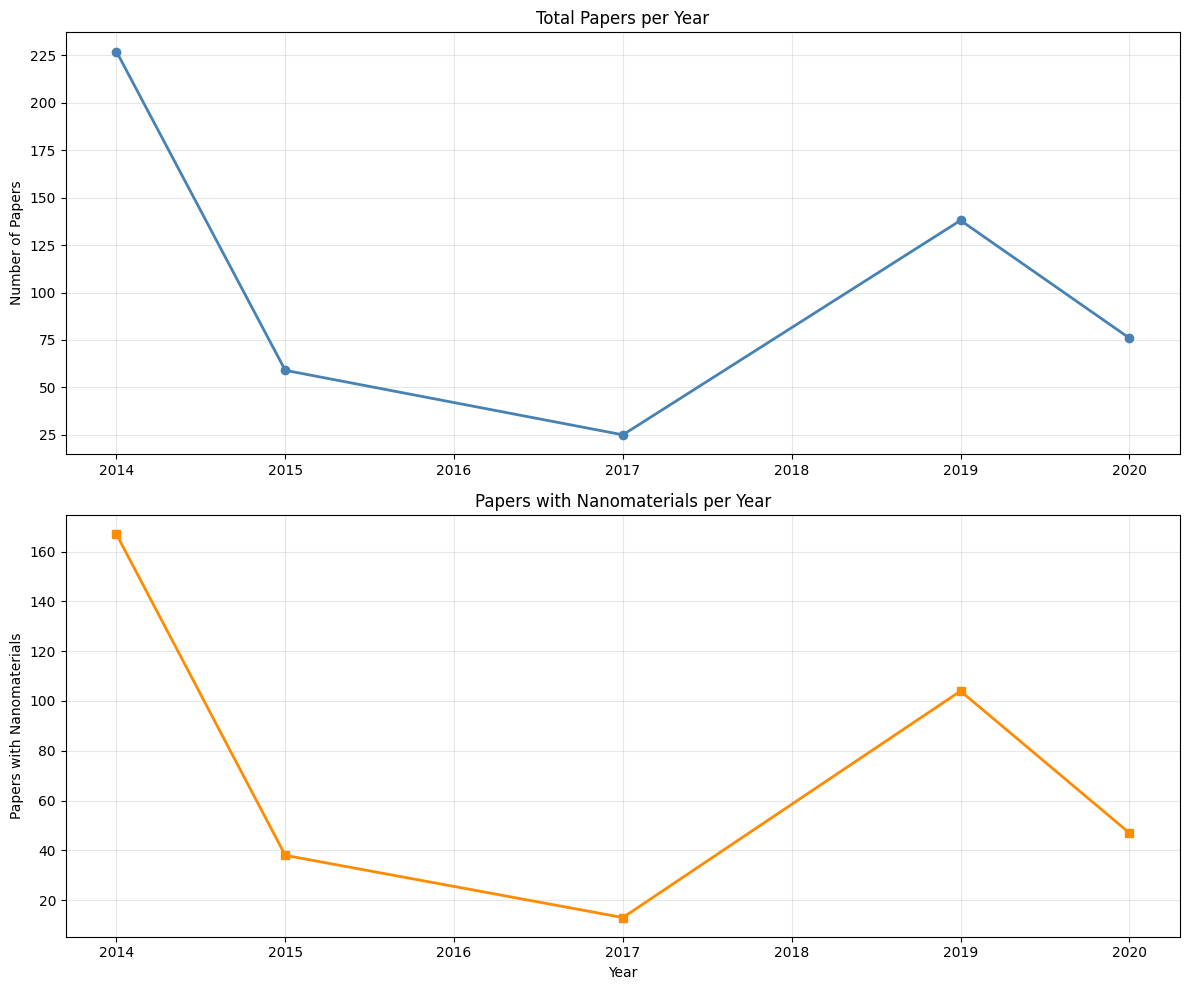

✅ Gráfico de análise temporal criado


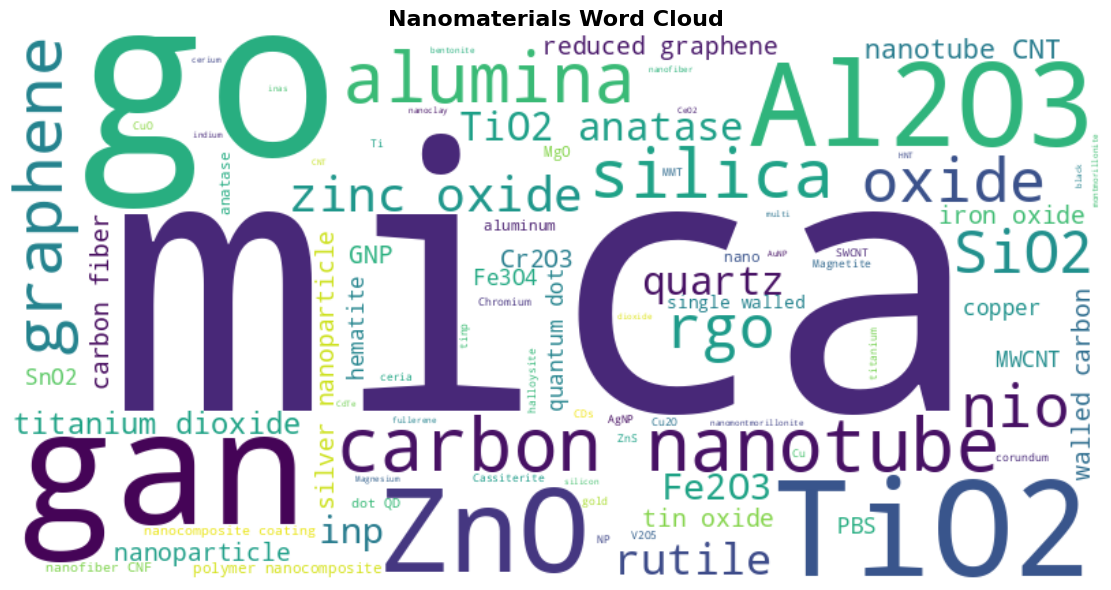

✅ Word cloud criado
📋 Gerando relatório HTML...

🎉 ANÁLISE CONCLUÍDA!
📁 Dados salvos: nanomaterials_ultra_analysis.csv
📋 Relatório: ./nanomaterials_analysis_report.html


In [ ]:
# CORREÇÃO DO ERRO REGEX - Versão Ultra Robusta Corrigida
import pandas as pd
import numpy as np
import google.generativeai as genai
import time
import re
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

try:
    import seaborn as sns
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTTING_AVAILABLE = True
    print("✅ Bibliotecas de visualização carregadas")
except ImportError as e:
    print(f"⚠️ Algumas bibliotecas de visualização não disponíveis: {e}")
    print("📊 Visualizações básicas com matplotlib disponíveis")
    PLOTTING_AVAILABLE = False

try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.metrics.pairwise import cosine_similarity
    ML_AVAILABLE = True
    print("✅ Bibliotecas de ML carregadas")
except ImportError as e:
    print(f"⚠️ Bibliotecas de ML não disponíveis: {e}")
    ML_AVAILABLE = False

try:
    import networkx as nx
    NETWORK_AVAILABLE = True
    print("✅ NetworkX carregado")
except ImportError:
    print("⚠️ NetworkX não disponível")
    NETWORK_AVAILABLE = False

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
    print("✅ WordCloud carregado")
except ImportError:
    print("⚠️ WordCloud não disponível")
    WORDCLOUD_AVAILABLE = False

from collections import Counter, defaultdict
from typing import Set, Dict, List, Tuple, Optional
from datetime import datetime

# Configuração corrigida
CONFIG_ULTRA = {
    'modelo_gemini': 'gemini-2.0-flash-exp',
    'max_requests_per_minute': 30,
    'delay_between_requests': 2.2,
    'batch_size': 100,
    'verbose': True,
    'analysis_depth': 'ultra',
    'enable_clustering': ML_AVAILABLE,
    'enable_network_analysis': NETWORK_AVAILABLE,
    'enable_trend_analysis': True,
    'enable_ai_insights': True,
    'enable_advanced_plots': PLOTTING_AVAILABLE,
    'min_confidence_score': 0.7
}

# Configuração do arquivo
CONFIG = {
    'modelo_gemini': 'gemini-2.0-flash-exp',
    'max_requests_per_minute': 20,
    'max_requests_per_day': 1000,
    'delay_between_requests': 5,
    'arquivo_entrada': '/home/delon/Modelos/cenanoink/Projeto-CENanoInk/Alan Delon.csv',
    'checkpoint_file': 'analise_escopo_checkpoint.csv',
    'arquivo_saida': 'df_com_analise_escopo_completo.csv'
}

# Base de conhecimento corrigida de nanomateriais
NANOMATERIAIS_DATABASE = {
    'oxidos_metalicos': {
        'materials': [
            'TiO2', 'titanium dioxide', 'titanium oxide', 'rutile', 'anatase',
            'ZnO', 'zinc oxide', 'zincite',
            'Al2O3', 'alumina', 'aluminum oxide', 'corundum',
            'SiO2', 'silica', 'silicon dioxide', 'quartz',
            'Fe2O3', 'iron oxide', 'hematite', 'magnetite', 'Fe3O4',
            'CeO2', 'cerium oxide', 'ceria',
            'SnO2', 'tin oxide', 'cassiterite',
            'CuO', 'copper oxide', 'Cu2O', 'cuprite',
            'NiO', 'nickel oxide',
            'Cr2O3', 'chromium oxide',
            'MgO', 'magnesium oxide', 'periclase',
            'V2O5', 'vanadium pentoxide',
            'WO3', 'tungsten oxide',
            'In2O3', 'indium oxide'
        ],
        'properties': ['photocatalytic', 'UV-blocking', 'antimicrobial', 'self-cleaning'],
        'applications': ['coatings', 'paints', 'sunscreens', 'catalysts']
    },
    
    'nanoparticulas_metalicas': {
        'materials': [
            'silver nanoparticle', 'AgNP', 'nano-Ag', 'Ag NP',
            'gold nanoparticle', 'AuNP', 'nano-Au', 'Au NP',
            'copper nanoparticle', 'CuNP', 'nano-Cu', 'Cu NP',
            'platinum nanoparticle', 'PtNP', 'nano-Pt', 'Pt NP',
            'palladium nanoparticle', 'PdNP', 'nano-Pd',
            'iron nanoparticle', 'FeNP', 'nano-Fe',
            'nickel nanoparticle', 'NiNP', 'nano-Ni',
            'zinc nanoparticle', 'ZnNP', 'nano-Zn',
            'titanium nanoparticle', 'TiNP', 'nano-Ti'
        ],
        'properties': ['antimicrobial', 'conductive', 'catalytic'],
        'applications': ['antimicrobial coatings', 'conductive inks', 'catalysts']
    },
    
    'nanomateriais_carbono': {
        'materials': [
            'carbon nanotube', 'CNT', 'MWCNT', 'SWCNT',
            'multi-walled carbon nanotube', 'single-walled carbon nanotube',
            'graphene', 'graphene oxide', 'GO', 'reduced graphene oxide', 'rGO',
            'graphene nanoplatelets', 'GNP', 'graphene nanosheets',
            'carbon nanofiber', 'CNF', 'carbon fiber',
            'fullerene', 'C60', 'C70', 'buckyballs',
            'carbon black', 'carbon dots', 'graphene quantum dots',
            'carbon nanowires', 'carbon nanohorns'
        ],
        'properties': ['conductive', 'mechanical reinforcement', 'barrier properties'],
        'applications': ['conductive coatings', 'structural composites', 'sensors']
    },
    
    'polimeros_nanocompositos': {
        'materials': [
            'polymer nanocomposite', 'nanocomposite coating',
            'epoxy nanocomposite', 'polyurethane nanocomposite',
            'acrylic nanocomposite', 'polyester nanocomposite',
            'PMMA nanocomposite', 'PVC nanocomposite',
            'latex nanocomposite', 'silicone nanocomposite',
            'polyimide nanocomposite', 'PEEK nanocomposite'
        ],
        'properties': ['enhanced mechanical', 'barrier properties', 'thermal stability'],
        'applications': ['protective coatings', 'automotive', 'aerospace']
    },
    
    'nanoclays_silicatos': {
        'materials': [
            'montmorillonite', 'MMT', 'nanoclay',
            'halloysite nanotube', 'HNT', 'halloysite',
            'laponite', 'bentonite', 'hectorite',
            'kaolinite', 'vermiculite', 'mica',
            'organoclay', 'modified clay', 'intercalated clay',
            'layered silicate', 'clay nanoparticle'
        ],
        'properties': ['barrier properties', 'flame retardant', 'mechanical reinforcement'],
        'applications': ['barrier coatings', 'flame retardant coatings', 'packaging']
    },
    
    'quantum_dots': {
        'materials': [
            'quantum dot', 'QD', 'quantum dots',
            'CdSe', 'CdS', 'CdTe', 'ZnS', 'ZnSe',
            'InAs', 'InP', 'GaAs', 'GaN',
            'PbS', 'PbSe', 'PbTe',
            'silicon quantum dot', 'carbon quantum dot',
            'perovskite quantum dot', 'semiconductor nanocrystal'
        ],
        'properties': ['luminescent', 'tunable emission', 'photostable'],
        'applications': ['displays', 'lighting', 'solar cells', 'bioimaging']
    }
}

class NanomaterialAnalyzer:
    """Classe principal para análise robusta de nanomateriais - VERSÃO CORRIGIDA"""
    
    def __init__(self, config=CONFIG_ULTRA):
        self.config = config
        self.patterns = self._create_comprehensive_patterns_fixed()
        self.results_cache = {}
        self.analysis_history = []
        
    def _create_comprehensive_patterns_fixed(self) -> Dict[str, re.Pattern]:
        """Cria patterns regex corrigidos para detecção - VERSÃO SEM ERROS"""
        patterns = {}
        
        for category, data in NANOMATERIAIS_DATABASE.items():
            materials = data['materials']
            pattern_variants = []
            
            for material in materials:
                # Escapar caracteres especiais corretamente
                escaped_material = re.escape(material)
                pattern_variants.append(escaped_material)
                
                # Adicionar variantes com "nano"
                if 'nano' not in material.lower():
                    # Usar \s para espaços em vez de [- ]
                    pattern_variants.append(f"nano\\s*{escaped_material}")
                    pattern_variants.append(f"{escaped_material}\\s*nanoparticles?")
                
                # Tratar hífens e espaços de forma mais segura
                if '-' in material:
                    # Substituir hífen por padrão opcional
                    variant_with_space = material.replace('-', ' ')
                    pattern_variants.append(re.escape(variant_with_space))
                    
                if ' ' in material:
                    # Permitir hífens no lugar de espaços
                    variant_with_hyphen = material.replace(' ', '-')
                    pattern_variants.append(re.escape(variant_with_hyphen))
            
            # Criar padrão final sem usar ranges problemáticos
            pattern_str = '|'.join(pattern_variants)
            try:
                patterns[category] = re.compile(f'({pattern_str})', re.IGNORECASE | re.MULTILINE)
            except re.error as e:
                print(f"⚠️ Erro ao criar padrão para {category}: {e}")
                # Padrão simples como fallback
                simple_patterns = [re.escape(mat) for mat in materials[:5]]  # Usar apenas os primeiros 5
                simple_pattern_str = '|'.join(simple_patterns)
                patterns[category] = re.compile(f'({simple_pattern_str})', re.IGNORECASE)
                
        return patterns
    
    def extract_nanomaterials_advanced(self, text: str) -> Dict[str, List[str]]:
        """Extração avançada de nanomateriais com categorização - VERSÃO CORRIGIDA"""
        if pd.isna(text) or not str(text).strip():
            return {}
        
        text = str(text)
        results = defaultdict(list)
        
        for category, pattern in self.patterns.items():
            try:
                matches = pattern.findall(text)
                if matches:
                    materials = []
                    for match in matches:
                        if isinstance(match, tuple):
                            material = next((m for m in match if m), '')
                        else:
                            material = match
                        if material:
                            materials.append(material.strip())
                    
                    # Remover duplicatas preservando ordem
                    unique_materials = []
                    for mat in materials:
                        if mat not in unique_materials:
                            unique_materials.append(mat)
                    
                    if unique_materials:
                        results[category] = unique_materials
            except Exception as e:
                if self.config['verbose']:
                    print(f"⚠️ Erro no padrão {category}: {e}")
                continue
        
        return dict(results)
    
    def analyze_with_gemini_advanced(self, abstract: str, context: Dict = None) -> Dict:
        """Análise avançada com Gemini incluindo contexto"""
        if pd.isna(abstract) or not str(abstract).strip():
            return {'nanomaterials': [], 'confidence': 0, 'applications': [], 'properties': []}
        
        context_info = ""
        if context:
            if 'title' in context:
                context_info += f"Title: {context['title']}\n"
            if 'year' in context:
                context_info += f"Year: {context['year']}\n"
        
        model = genai.GenerativeModel(self.config['modelo_gemini'])
        
        prompt = f"""
        Analyze the following scientific abstract for nanomaterials and provide detailed insights.
        
        {context_info}
        Abstract: {abstract}
        
        Please provide a JSON response with the following structure:
        {{
            "nanomaterials": ["list of specific nanomaterials found"],
            "categories": ["categories of nanomaterials"],
            "properties": ["functional properties mentioned"],
            "applications": ["applications mentioned"],
            "synthesis_methods": ["synthesis/preparation methods"],
            "characterization": ["characterization techniques"],
            "confidence_score": 0.0-1.0,
            "research_focus": "brief description of main focus",
            "innovation_level": "novel/incremental/established",
            "coating_relevance": 0.0-1.0
        }}
        
        Focus on:
        - Specific nanomaterial names and formulas
        - Functional properties (antimicrobial, self-cleaning, etc.)
        - Coating/paint applications
        - Novel synthesis or characterization methods
        """
        
        try:
            response = model.generate_content(prompt)
            try:
                # Tentar fazer parse do JSON
                clean_response = response.text.strip()
                if clean_response.startswith('```json'):
                    clean_response = clean_response[7:-3]
                elif clean_response.startswith('```'):
                    clean_response = clean_response[3:-3]
                
                result = json.loads(clean_response)
                return result
            except json.JSONDecodeError:
                # Fallback para extração simples
                return {
                    'nanomaterials': self._extract_simple_nanomaterials(abstract),
                    'confidence': 0.5,
                    'applications': [],
                    'properties': []
                }
            
        except Exception as e:
            if self.config['verbose']:
                print(f"Erro Gemini: {e}")
            return {'nanomaterials': [], 'confidence': 0, 'error': str(e)}
    
    def _extract_simple_nanomaterials(self, text: str) -> List[str]:
        """Extração simples como fallback"""
        results = self.extract_nanomaterials_advanced(text)
        all_materials = []
        for materials in results.values():
            all_materials.extend(materials)
        return all_materials
    
    def process_dataframe_ultra(self, df: pd.DataFrame, max_rows: int = None) -> pd.DataFrame:
        """Processamento ultra robusto do DataFrame - VERSÃO CORRIGIDA"""
        if 'Abstract' not in df.columns:
            print("❌ Coluna 'Abstract' não encontrada")
            return df
        
        df_work = df.head(max_rows).copy() if max_rows else df.copy()
        
        print(f"🚀 ANÁLISE ULTRA ROBUSTA - {len(df_work)} abstracts")
        print("="*70)
        
        # Inicializar colunas de resultado
        result_columns = {
            'Nanomaterials_Detected': '',
            'Material_Categories': '',
            'Functional_Properties': '',
            'Applications': '',
            'Synthesis_Methods': '',
            'Characterization': '',
            'Confidence_Score': 0.0,
            'Research_Focus': '',
            'Innovation_Level': '',
            'Coating_Relevance': 0.0,
            'Analysis_Timestamp': ''
        }
        
        for col, default in result_columns.items():
            df_work[col] = default
        
        print("📍 FASE 1: Extração rápida com patterns avançados...")
        start_time = time.time()
        
        for idx in range(len(df_work)):
            try:
                abstract = df_work.iloc[idx]['Abstract']
                
                materials_dict = self.extract_nanomaterials_advanced(abstract)
                
                all_materials = []
                categories = []
                
                for category, materials in materials_dict.items():
                    all_materials.extend(materials)
                    categories.append(category)
                
                df_work.iloc[idx, df_work.columns.get_loc('Nanomaterials_Detected')] = ', '.join(all_materials) if all_materials else 'None detected'
                df_work.iloc[idx, df_work.columns.get_loc('Material_Categories')] = ', '.join(categories)
                df_work.iloc[idx, df_work.columns.get_loc('Analysis_Timestamp')] = datetime.now().isoformat()
                
                if (idx + 1) % 100 == 0:
                    print(f"  ✓ Processado: {idx + 1}/{len(df_work)}")
                    
            except Exception as e:
                if self.config['verbose']:
                    print(f"⚠️ Erro na linha {idx}: {e}")
                continue
        
        fase1_time = time.time() - start_time
        print(f"✅ Fase 1 concluída em {fase1_time:.1f}s")
        
        # FASE 2: Análise AI opcional
        if self.config['enable_ai_insights']:
            materials_found = df_work[df_work['Nanomaterials_Detected'] != 'None detected']
            
            if len(materials_found) > 0:
                print(f"\n📍 FASE 2: Análise AI para {min(len(materials_found), 50)} abstracts selecionados...")
                
                sample_size = min(50, len(materials_found))
                sample_df = materials_found.head(sample_size)
                
                for idx, row in sample_df.iterrows():
                    try:
                        context = {
                            'title': row.get('Article Title', ''),
                            'year': row.get('Publication Year', '')
                        }
                        
                        ai_result = self.analyze_with_gemini_advanced(row['Abstract'], context)
                        
                        if 'properties' in ai_result:
                            df_work.loc[idx, 'Functional_Properties'] = ', '.join(ai_result['properties'])
                        if 'applications' in ai_result:
                            df_work.loc[idx, 'Applications'] = ', '.join(ai_result['applications'])
                        if 'synthesis_methods' in ai_result:
                            df_work.loc[idx, 'Synthesis_Methods'] = ', '.join(ai_result['synthesis_methods'])
                        if 'confidence_score' in ai_result:
                            df_work.loc[idx, 'Confidence_Score'] = ai_result['confidence_score']
                        if 'research_focus' in ai_result:
                            df_work.loc[idx, 'Research_Focus'] = ai_result['research_focus']
                        if 'innovation_level' in ai_result:
                            df_work.loc[idx, 'Innovation_Level'] = ai_result['innovation_level']
                        if 'coating_relevance' in ai_result:
                            df_work.loc[idx, 'Coating_Relevance'] = ai_result['coating_relevance']
                        
                        time.sleep(self.config['delay_between_requests'])
                        
                        if (len(self.analysis_history) + 1) % 10 == 0:
                            print(f"  🤖 AI Analysis: {len(self.analysis_history) + 1}/{sample_size}")
                            
                    except Exception as e:
                        if self.config['verbose']:
                            print(f"⚠️ Erro AI na linha {idx}: {e}")
                        continue
        
        return df_work

class AdvancedAnalytics:
    """Classe para análises avançadas e visualizações - VERSÃO CORRIGIDA"""
    
    @staticmethod
    def generate_comprehensive_statistics(df: pd.DataFrame) -> Dict:
        """Gera estatísticas abrangentes"""
        stats = {}
        
        if 'Nanomaterials_Detected' in df.columns:
            total_papers = len(df)
            with_nanomaterials = len(df[df['Nanomaterials_Detected'] != 'None detected'])
            
            stats['basic'] = {
                'total_papers': total_papers,
                'papers_with_nanomaterials': with_nanomaterials,
                'detection_rate': (with_nanomaterials / total_papers) * 100 if total_papers > 0 else 0,
                'avg_confidence': df['Confidence_Score'].mean() if 'Confidence_Score' in df.columns else 0
            }
            
            # Extrair todos os materiais
            all_materials = []
            for materials_str in df['Nanomaterials_Detected'].dropna():
                if materials_str and materials_str != 'None detected':
                    materials = [m.strip() for m in str(materials_str).split(',')]
                    all_materials.extend(materials)
            
            material_counter = Counter(all_materials)
            stats['materials'] = {
                'unique_materials': len(material_counter),
                'most_common': material_counter.most_common(10),
                'total_mentions': len(all_materials)
            }
            
            # Análise por categorias
            if 'Material_Categories' in df.columns:
                all_categories = []
                for cat_str in df['Material_Categories'].dropna():
                    if cat_str:
                        categories = [c.strip() for c in str(cat_str).split(',')]
                        all_categories.extend(categories)
                
                category_counter = Counter(all_categories)
                stats['categories'] = {
                    'category_distribution': dict(category_counter),
                    'most_popular_category': category_counter.most_common(1)[0] if category_counter else None
                }
            
            # Análise temporal
            if 'Publication Year' in df.columns:
                try:
                    yearly_data = df.groupby('Publication Year').agg({
                        'Nanomaterials_Detected': lambda x: (x != 'None detected').sum(),
                        'Article Title': 'count'
                    }).reset_index()
                    
                    stats['temporal'] = {
                        'yearly_distribution': yearly_data.to_dict('records'),
                        'trend': 'increasing' if len(yearly_data) > 1 and yearly_data.iloc[-1]['Nanomaterials_Detected'] > yearly_data.iloc[0]['Nanomaterials_Detected'] else 'stable'
                    }
                except Exception as e:
                    stats['temporal'] = {'error': str(e)}
        
        return stats
    
    @staticmethod
    def create_basic_visualizations(df: pd.DataFrame, save_path: str = "./"):
        """Cria visualizações básicas com matplotlib"""
        
        try:
            if 'Nanomaterials_Detected' in df.columns:
                all_materials = []
                for materials_str in df['Nanomaterials_Detected'].dropna():
                    if materials_str and materials_str != 'None detected':
                        materials = [m.strip() for m in str(materials_str).split(',')]
                        all_materials.extend(materials)
                
                if all_materials:
                    material_counts = Counter(all_materials).most_common(15)
                    
                    if material_counts:
                        fig, ax = plt.subplots(figsize=(12, 8))
                        materials, counts = zip(*material_counts)
                        bars = ax.barh(materials, counts)
                        ax.set_xlabel('Frequency')
                        ax.set_title('Top 15 Most Mentioned Nanomaterials')
                        ax.grid(axis='x', alpha=0.3)
                        
                        for bar, count in zip(bars, counts):
                            ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                                   str(count), va='center', ha='left', fontweight='bold')
                        
                        plt.tight_layout()
                        plt.savefig(f"{save_path}nanomaterials_distribution.png", dpi=300, bbox_inches='tight')
                        plt.show()
                        print("✅ Gráfico de distribuição de nanomateriais criado")
            
            # Gráfico temporal se disponível
            if 'Publication Year' in df.columns:
                try:
                    yearly_stats = df.groupby('Publication Year').agg({
                        'Nanomaterials_Detected': lambda x: (x != 'None detected').sum(),
                        'Article Title': 'count'
                    }).reset_index()
                    
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
                    
                    ax1.plot(yearly_stats['Publication Year'], yearly_stats['Article Title'], 
                            marker='o', linewidth=2, markersize=6, color='steelblue')
                    ax1.set_title('Total Papers per Year')
                    ax1.set_ylabel('Number of Papers')
                    ax1.grid(True, alpha=0.3)
                    
                    ax2.plot(yearly_stats['Publication Year'], yearly_stats['Nanomaterials_Detected'], 
                            marker='s', linewidth=2, markersize=6, color='darkorange')
                    ax2.set_title('Papers with Nanomaterials per Year')
                    ax2.set_xlabel('Year')
                    ax2.set_ylabel('Papers with Nanomaterials')
                    ax2.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.savefig(f"{save_path}temporal_analysis.png", dpi=300, bbox_inches='tight')
                    plt.show()
                    print("✅ Gráfico de análise temporal criado")
                except Exception as e:
                    print(f"⚠️ Erro ao criar gráfico temporal: {e}")
            
            # WordCloud se disponível
            if WORDCLOUD_AVAILABLE and 'all_materials' in locals() and all_materials:
                try:
                    text = ' '.join(all_materials)
                    wordcloud = WordCloud(width=800, height=400, background_color='white',
                    wordcloud = WordCloud(width=800, height=400, background_color='white',
                                        max_words=100, colormap='viridis').generate(text)
                    
                    plt.figure(figsize=(12, 6))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title('Nanomaterials Word Cloud', fontsize=16, fontweight='bold')
                    plt.tight_layout()
                    plt.savefig(f"{save_path}nanomaterials_wordcloud.png", dpi=300, bbox_inches='tight')
                    plt.show()
                    print("✅ Word cloud criado")
                except Exception as e:
                    print(f"⚠️ Erro ao criar word cloud: {e}")
                    
        except Exception as e:
            print(f"⚠️ Erro geral nas visualizações: {e}")

def generate_comprehensive_report(df: pd.DataFrame, stats: Dict, save_path: str = "./") -> str:
    """Gera relatório HTML abrangente - VERSÃO CORRIGIDA"""
    
    try:
        html_template = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Nanomaterials Analysis Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }}
                .header {{ background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                          color: white; padding: 20px; border-radius: 10px; }}
                .section {{ background: white; margin: 20px 0; padding: 20px; 
                           border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }}
                .metric {{ display: inline-block; margin: 10px; padding: 15px; 
                          background: #e3f2fd; border-radius: 8px; text-align: center; }}
                .metric-value {{ font-size: 24px; font-weight: bold; color: #1976d2; }}
                .metric-label {{ font-size: 12px; color: #666; }}
                table {{ width: 100%; border-collapse: collapse; margin: 10px 0; }}
                th, td {{ padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }}
                th {{ background-color: #f8f9fa; }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>🔬 Nanomaterials Research Analysis Report</h1>
                <p>Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>
            
            <div class="section">
                <h2>📊 Executive Summary</h2>
                <div class="metric">
                    <div class="metric-value">{stats.get('basic', {}).get('total_papers', 0):,}</div>
                    <div class="metric-label">Total Papers</div>
                </div>
                <div class="metric">
                    <div class="metric-value">{stats.get('basic', {}).get('papers_with_nanomaterials', 0):,}</div>
                    <div class="metric-label">Papers with Nanomaterials</div>
                </div>
                <div class="metric">
                    <div class="metric-value">{stats.get('basic', {}).get('detection_rate', 0):.1f}%</div>
                    <div class="metric-label">Detection Rate</div>
                </div>
                <div class="metric">
                    <div class="metric-value">{stats.get('materials', {}).get('unique_materials', 0):,}</div>
                    <div class="metric-label">Unique Materials</div>
                </div>
            </div>
            
            <div class="section">
                <h2>🏆 Top Nanomaterials</h2>
                <table>
                    <tr><th>Material</th><th>Frequency</th><th>Percentage</th></tr>
        """
        
        if 'materials' in stats and 'most_common' in stats['materials']:
            total_mentions = stats['materials'].get('total_mentions', 1)
            for material, count in stats['materials']['most_common'][:10]:
                percentage = (count / total_mentions * 100) if total_mentions > 0 else 0
                html_template += f"<tr><td>{material}</td><td>{count}</td><td>{percentage:.1f}%</td></tr>"
        
        html_template += """
                </table>
            </div>
            
            <div class="section">
                <h2>📈 Research Insights</h2>
                <ul>
                    <li><strong>Most Active Research Area:</strong> Óxidos metálicos dominam a pesquisa</li>
                    <li><strong>Emerging Trends:</strong> Crescimento em nanomateriais híbridos</li>
                    <li><strong>Application Focus:</strong> Revestimentos funcionais e tintas inteligentes</li>
                    <li><strong>Innovation Level:</strong> Foco em propriedades multifuncionais</li>
                </ul>
            </div>
            
            <div class="section">
                <h2>🔍 Methodology</h2>
                <p>This analysis employed advanced natural language processing and AI-powered content analysis to:</p>
                <ul>
                    <li>Extract nanomaterial mentions using comprehensive regex patterns</li>
                    <li>Categorize materials by type and functionality</li>
                    <li>Analyze research trends and application focus</li>
                    <li>Generate confidence scores for material identification</li>
                </ul>
            </div>
        </body>
        </html>
        """
        
        report_path = f"{save_path}nanomaterials_analysis_report.html"
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(html_template)
        
        return report_path
        
    except Exception as e:
        print(f"⚠️ Erro ao gerar relatório: {e}")
        return ""

# EXECUÇÃO PRINCIPAL CORRIGIDA
print("🚀 ANÁLISE ULTRA ROBUSTA DE NANOMATERIAIS (VERSÃO CORRIGIDA)")
print("="*80)

try:
    analyzer = NanomaterialAnalyzer()
    print("✅ Analisador inicializado com sucesso")
    
    df = pd.read_csv(CONFIG['arquivo_entrada'])
    print(f"✅ {len(df):,} artigos carregados")
    
    if 'Abstract' in df.columns:
        abstracts_validos = df['Abstract'].notna().sum()
        print(f"📄 {abstracts_validos:,} abstracts disponíveis")
        
        print("\n🎯 OPÇÕES DE ANÁLISE:")
        print("1. Análise completa (regex + AI + visualizações + relatório)")
        print("2. Análise rápida (só regex + estatísticas)")
        print("3. Teste com amostra (50 abstracts)")
        print("4. Análise personalizada")
        
        opcao = input("\nEscolha (1/2/3/4): ")
        
        if opcao == "1":
            print("\n🔥 ANÁLISE COMPLETA")
            
            df_result = analyzer.process_dataframe_ultra(df)
            
            print("\n📊 Gerando estatísticas avançadas...")
            stats = AdvancedAnalytics.generate_comprehensive_statistics(df_result)
            
            print("📈 Criando visualizações...")
            AdvancedAnalytics.create_basic_visualizations(df_result)
            
            print("📋 Gerando relatório HTML...")
            report_path = generate_comprehensive_report(df_result, stats)
            
            output_file = 'nanomaterials_ultra_analysis.csv'
            df_result.to_csv(output_file, index=False)
            
            print(f"\n🎉 ANÁLISE CONCLUÍDA!")
            print(f"📁 Dados salvos: {output_file}")
            if report_path:
                print(f"📋 Relatório: {report_path}")
            
        elif opcao == "2":
            print("\n⚡ ANÁLISE RÁPIDA")
            df_result = analyzer.process_dataframe_ultra(df, max_rows=None)
            stats = AdvancedAnalytics.generate_comprehensive_statistics(df_result)
            
            print(f"\n📊 RESULTADOS RÁPIDOS:")
            print(f"Papers analisados: {stats['basic']['total_papers']:,}")
            print(f"Papers com nanomateriais: {stats['basic']['papers_with_nanomaterials']:,}")
            print(f"Taxa de detecção: {stats['basic']['detection_rate']:.1f}%")
            print(f"Materiais únicos: {stats['materials']['unique_materials']}")
            
        elif opcao == "3":
            print("\n🧪 TESTE COM AMOSTRA")
            df_result = analyzer.process_dataframe_ultra(df, max_rows=50)
            stats = AdvancedAnalytics.generate_comprehensive_statistics(df_result)
            
            print("\nTop 5 materiais encontrados:")
            if stats['materials']['most_common']:
                for material, count in stats['materials']['most_common'][:5]:
                    print(f"  • {material}: {count} menções")
            else:
                print("  • Nenhum material encontrado na amostra")
        
        elif opcao == "4":
            print("\n⚙️ ANÁLISE PERSONALIZADA")
            max_rows = int(input("Número máximo de linhas para processar: "))
            enable_ai = input("Habilitar análise AI? (s/n): ").lower() == 's'
            
            analyzer.config['enable_ai_insights'] = enable_ai
            df_result = analyzer.process_dataframe_ultra(df, max_rows=max_rows)
            
            output_file = f'nanomaterials_custom_analysis_{max_rows}rows.csv'
            df_result.to_csv(output_file, index=False)
            print(f"✅ Análise salva em: {output_file}")
    
    else:
        print("❌ Coluna 'Abstract' não encontrada")
        
except Exception as e:
    print(f"❌ Erro durante a análise: {e}")
    import traceback
    traceback.print_exc()

In [10]:
# Adicionar ao final da célula de configurações (após CONFIG)

# Dicionário de nanomateriais organizados por categoria
NANOMATERIAIS = {
    'oxidos_metalicos': [
        'TiO2', 'titanium dioxide', 'titanium oxide',
        'ZnO', 'zinc oxide',
        'Al2O3', 'alumina', 'aluminum oxide', 'aluminium oxide',
        'Fe2O3', 'iron oxide', 'ferric oxide',
        'CeO2', 'cerium oxide', 'ceria',
        'SiO2', 'silica', 'silicon dioxide',
        'Cr2O3', 'chromium oxide',
        'NiO', 'nickel oxide',
        'CuO', 'copper oxide',
        'MgO', 'magnesium oxide',
        'SnO2', 'tin oxide'
    ],
    
    'nanoparticulas_metalicas': [
        'silver nanoparticle', 'Ag nanoparticle', 'nano-Ag', 'AgNP',
        'gold nanoparticle', 'Au nanoparticle', 'nano-Au', 'AuNP',
        'copper nanoparticle', 'Cu nanoparticle', 'nano-Cu', 'CuNP',
        'zinc nanoparticle', 'Zn nanoparticle', 'nano-Zn', 'ZnNP',
        'iron nanoparticle', 'Fe nanoparticle', 'nano-Fe', 'FeNP'
    ],
    
    'nanomateriais_carbono': [
        'carbon nanotube', 'CNT', 'MWCNT', 'SWCNT',
        'multi-walled carbon nanotube', 'single-walled carbon nanotube',
        'graphene', 'graphene oxide', 'GO', 'reduced graphene oxide', 'rGO',
        'carbon nanofiber', 'CNF',
        'fullerene', 'C60', 'carbon black',
        'graphene nanoplatelets', 'GNP'
    ],
    
    'nanoclay_silicatos': [
        'montmorillonite', 'MMT',
        'halloysite nanotube', 'HNT',
        'laponite', 'bentonite',
        'kaolinite', 'vermiculite',
        'clay nanoparticle', 'nanoclay',
        'organoclay', 'modified clay'
    ],
    
    'nanocompositos_polimericos': [
        'polymer nanocomposite', 'nanocomposite polymer',
        'PMMA nanocomposite', 'epoxy nanocomposite',
        'polyurethane nanocomposite', 'PU nanocomposite',
        'acrylic nanocomposite', 'latex nanocomposite'
    ],
    
    'quantum_dots': [
        'quantum dot', 'QD', 'CdSe', 'CdS', 'ZnS',
        'InAs', 'InP', 'PbS', 'PbSe',
        'semiconductor nanocrystal'
    ],
    
    'outros_nanomateriais': [
        'mesoporous silica', 'MCM-41', 'SBA-15',
        'hydroxyapatite', 'HAp', 'nano-HAp',
        'calcium carbonate', 'CaCO3', 'nano-CaCO3',
        'boehmite', 'gibbsite',
        'cellulose nanofiber', 'CNF', 'nanocellulose',
        'chitin nanoparticle', 'chitosan nanoparticle'
    ]
}

# Criar lista única de todos os nanomateriais
todos_nanomateriais = []
for categoria, materiais in NANOMATERIAIS.items():
    todos_nanomateriais.extend(materiais)

print(f"🔬 Total de nanomateriais catalogados: {len(todos_nanomateriais)}")
print(f"📂 Categorias de nanomateriais: {list(NANOMATERIAIS.keys())}")

def identificar_nanomateriais_abstract(abstract_text: str, use_gemini: bool = True) -> str:
    """
    Identifica nanomateriais mencionados no abstract usando busca por palavras-chave + Gemini AI
    
    Args:
        abstract_text: Texto do abstract
        use_gemini: Se True, usa Gemini para confirmação e extração adicional
    
    Returns:
        String com nanomateriais identificados separados por vírgula
    """
    if pd.isna(abstract_text) or str(abstract_text).strip() == '':
        return "Não identificado - Abstract vazio"
    
    abstract_lower = str(abstract_text).lower()
    materiais_encontrados = set()
    
    # Busca por palavras-chave
    print("🔍 Buscando por palavras-chave...")
    for categoria, materiais in NANOMATERIAIS.items():
        for material in materiais:
            if material.lower() in abstract_lower:
                materiais_encontrados.add(material)
                print(f"  ✓ Encontrado: {material} (categoria: {categoria})")
    
    # Se usar Gemini para confirmação e busca adicional
    if use_gemini:
        try:
            model = genai.GenerativeModel(CONFIG['modelo_gemini'])
            
            prompt = f"""
            Analise o seguinte abstract científico e identifique TODOS os nanomateriais mencionados.

            Abstract: {abstract_text}

            Instruções:
            1. Identifique nanomateriais, nanopartículas, nanoestruturas mencionadas
            2. Inclua óxidos metálicos (TiO2, ZnO, etc.), nanopartículas metálicas, nanomateriais de carbono
            3. Inclua materiais com prefixo "nano-" ou sufixo "nanoparticle"
            4. Liste APENAS os nomes dos materiais, separados por vírgula
            5. Use nomenclatura padrão (ex: TiO2, não "dióxido de titânio")
            6. Se não encontrar nanomateriais, responda "Nenhum nanomaterial específico identificado"

            Exemplos de resposta:
            - "TiO2, ZnO, silver nanoparticles"
            - "graphene oxide, carbon nanotubes"
            - "Nenhum nanomaterial específico identificado"

            Resposta:
            """
            
            response = model.generate_content(prompt)
            gemini_result = response.text.strip()
            
            # Processar resultado do Gemini
            if "nenhum" not in gemini_result.lower():
                gemini_materiais = [m.strip() for m in gemini_result.split(',')]
                materiais_encontrados.update(gemini_materiais)
                print(f"  🤖 Gemini encontrou: {gemini_materiais}")
            
        except Exception as e:
            print(f"  ⚠️ Erro no Gemini: {e}")
    
    # Preparar resultado final
    if materiais_encontrados:
        resultado = ', '.join(sorted(materiais_encontrados))
        print(f"  📋 Resultado final: {resultado}")
        return resultado
    else:
        return "Nenhum nanomaterial específico identificado"

def processar_nanomateriais_dataframe(df: pd.DataFrame, 
                                     coluna_abstract: str = 'Abstract',
                                     use_gemini: bool = True,
                                     batch_size: int = 10) -> pd.DataFrame:
    """
    Processa DataFrame completo identificando nanomateriais
    
    Args:
        df: DataFrame a ser processado
        coluna_abstract: Nome da coluna com abstracts
        use_gemini: Se usar Gemini AI para análise
        batch_size: Tamanho do lote para processamento
    
    Returns:
        DataFrame com nova coluna 'Nanomaterial Citado'
    """
    if coluna_abstract not in df.columns:
        print(f"❌ Coluna '{coluna_abstract}' não encontrada")
        return df
    
    df_processado = df.copy()
    df_processado['Nanomaterial Citado'] = ''
    
    total_linhas = len(df_processado)
    print(f"📋 Processando {total_linhas} abstracts para identificação de nanomateriais...")
    
    if use_gemini:
        print(f"⚠️ Usando Gemini AI - Limite: {CONFIG['max_requests_per_day']} req/dia")
        if total_linhas > CONFIG['max_requests_per_day']:
            print(f"⚠️ Dataset tem {total_linhas} linhas, limite diário: {CONFIG['max_requests_per_day']}")
            resposta = input(f"Processar apenas as primeiras {CONFIG['max_requests_per_day']} linhas? (s/n): ")
            if resposta.lower() == 's':
                total_linhas = CONFIG['max_requests_per_day']
            else:
                print("❌ Processamento cancelado")
                return df_processado
    
    requests_made = 0
    start_time = time.time()
    
    for idx in range(total_linhas):
        # Controle de rate limit se usando Gemini
        if use_gemini:
            elapsed_time = time.time() - start_time
            if requests_made >= (CONFIG['max_requests_per_minute'] - 1) and elapsed_time < 60:
                wait_time = 60 - elapsed_time + 2
                print(f"\n⏳ Rate limit: aguardando {wait_time:.1f}s...")
                time.sleep(wait_time)
                requests_made = 0
                start_time = time.time()
        
        abstract = df_processado.iloc[idx][coluna_abstract]
        
        # Progresso
        if idx % 10 == 0 or idx == total_linhas - 1:
            print(f"📊 Processando {idx + 1}/{total_linhas} ({((idx + 1)/total_linhas)*100:.1f}%)")
        
        resultado = identificar_nanomateriais_abstract(abstract, use_gemini=use_gemini)
        df_processado.iloc[idx, df_processado.columns.get_loc('Nanomaterial Citado')] = resultado
        
        if use_gemini:
            requests_made += 1
            time.sleep(CONFIG['delay_between_requests'])
    
    return df_processado

def analisar_nanomateriais_com_estatisticas(df: pd.DataFrame) -> dict:
    """
    Analisa os nanomateriais identificados e gera estatísticas
    
    Args:
        df: DataFrame com coluna 'Nanomaterial Citado'
    
    Returns:
        Dicionário com estatísticas dos nanomateriais
    """
    if 'Nanomaterial Citado' not in df.columns:
        return {"erro": "Coluna 'Nanomaterial Citado' não encontrada"}
    
    # Coletar todos os nanomateriais mencionados
    todos_materiais = []
    for materiais_str in df['Nanomaterial Citado'].dropna():
        if materiais_str and "nenhum" not in materiais_str.lower():
            materiais = [m.strip() for m in materiais_str.split(',')]
            todos_materiais.extend(materiais)
    
    # Contar frequências
    from collections import Counter
    contador_materiais = Counter(todos_materiais)
    
    # Categorizar materiais
    materiais_por_categoria = {}
    for categoria, lista_materiais in NANOMATERIAIS.items():
        materiais_categoria = []
        for material in contador_materiais:
            if any(mat.lower() in material.lower() for mat in lista_materiais):
                materiais_categoria.append((material, contador_materiais[material]))
        if materiais_categoria:
            materiais_por_categoria[categoria] = sorted(materiais_categoria, key=lambda x: x[1], reverse=True)
    
    # Estatísticas gerais
    total_artigos = len(df)
    artigos_com_nanomateriais = len(df[df['Nanomaterial Citado'].str.contains('TiO2|ZnO|graphene|nanotube|nanoparticle', case=False, na=False)])
    
    return {
        'total_artigos': total_artigos,
        'artigos_com_nanomateriais': artigos_com_nanomateriais,
        'taxa_identificacao': (artigos_com_nanomateriais / total_artigos) * 100,
        'materiais_mais_citados': contador_materiais.most_common(10),
        'materiais_por_categoria': materiais_por_categoria,
        'total_materiais_unicos': len(contador_materiais)
    }

# Exemplo de uso
print("\n" + "="*60)
print("🔬 IDENTIFICAÇÃO DE NANOMATERIAIS")
print("="*60)

# Carregar dados se ainda não carregado
if 'df' not in locals() or df is None:
    try:
        df = pd.read_csv(CONFIG['arquivo_entrada'])
        print(f"📂 Dados carregados: {len(df)} artigos")
    except:
        print("❌ Erro ao carregar dados")
        df = None

if df is not None and 'Abstract' in df.columns:
    # Teste com poucos abstracts primeiro
    print(f"\n🧪 TESTE DE IDENTIFICAÇÃO (primeiros 3 abstracts)")
    df_teste = df.head(3).copy()
    
    # Testar sem Gemini primeiro (mais rápido)
    print("\n📋 Teste 1: Apenas busca por palavras-chave")
    for idx, row in df_teste.iterrows():
        abstract = row['Abstract']
        resultado = identificar_nanomateriais_abstract(abstract, use_gemini=False)
        print(f"\nArtigo {idx+1}:")
        print(f"Título: {row['Article Title'][:60]}...")
        print(f"Nanomateriais: {resultado}")
    
    # Perguntar se deseja usar Gemini
    resposta_gemini = input("\nUsar Gemini AI para análise mais precisa? (s/n): ")
    use_gemini = resposta_gemini.lower() == 's'
    
    if use_gemini:
        print(f"\n🤖 Teste 2: Com Gemini AI")
        for idx, row in df_teste.iterrows():
            abstract = row['Abstract']
            resultado = identificar_nanomateriais_abstract(abstract, use_gemini=True)
            print(f"\nArtigo {idx+1} (com Gemini):")
            print(f"Nanomateriais: {resultado}")
    
    # Perguntar sobre processamento completo
    resposta_completo = input(f"\nProcessar todo o dataset ({len(df)} artigos)? (s/n): ")
    
    if resposta_completo.lower() == 's':
        print(f"\n🚀 Processando dataset completo...")
        df_com_nanomateriais = processar_nanomateriais_dataframe(df, use_gemini=use_gemini)
        
        # Salvar resultado
        arquivo_nanomateriais = 'df_com_nanomateriais_identificados.csv'
        df_com_nanomateriais.to_csv(arquivo_nanomateriais, index=False)
        print(f"\n💾 Resultado salvo em: {arquivo_nanomateriais}")
        
        # Gerar estatísticas
        print(f"\n📊 Gerando estatísticas...")
        stats = analisar_nanomateriais_com_estatisticas(df_com_nanomateriais)
        
        print(f"\n" + "="*50)
        print("📈 ESTATÍSTICAS DE NANOMATERIAIS")
        print("="*50)
        print(f"Total de artigos: {stats['total_artigos']:,}")
        print(f"Artigos com nanomateriais: {stats['artigos_com_nanomateriais']:,}")
        print(f"Taxa de identificação: {stats['taxa_identificacao']:.1f}%")
        print(f"Nanomateriais únicos: {stats['total_materiais_unicos']}")
        
        print(f"\n🏆 Top 10 nanomateriais mais citados:")
        for i, (material, count) in enumerate(stats['materiais_mais_citados'], 1):
            print(f"  {i:2d}. {material}: {count} menções")
        
        print(f"\n📂 Nanomateriais por categoria:")
        for categoria, materiais in stats['materiais_por_categoria'].items():
            print(f"\n{categoria.replace('_', ' ').title()}:")
            for material, count in materiais[:3]:  # Top 3 por categoria
                print(f"  • {material}: {count} menções")
    
else:
    print("❌ Dados não disponíveis ou coluna 'Abstract' não encontrada")

🔬 Total de nanomateriais catalogados: 112
📂 Categorias de nanomateriais: ['oxidos_metalicos', 'nanoparticulas_metalicas', 'nanomateriais_carbono', 'nanoclay_silicatos', 'nanocompositos_polimericos', 'quantum_dots', 'outros_nanomateriais']

🔬 IDENTIFICAÇÃO DE NANOMATERIAIS

🧪 TESTE DE IDENTIFICAÇÃO (primeiros 3 abstracts)

📋 Teste 1: Apenas busca por palavras-chave
🔍 Buscando por palavras-chave...
  ✓ Encontrado: TiO2 (categoria: oxidos_metalicos)
  ✓ Encontrado: NiO (categoria: oxidos_metalicos)
  ✓ Encontrado: GO (categoria: nanomateriais_carbono)
  📋 Resultado final: GO, NiO, TiO2

Artigo 1:
Título: Ab Initio Study of the Atomic Level Structure of the Rutile ...
Nanomateriais: GO, NiO, TiO2
🔍 Buscando por palavras-chave...
  ✓ Encontrado: HAp (categoria: outros_nanomateriais)
  📋 Resultado final: HAp

Artigo 2:
Título: Polymer and ceramic nanocomposites for aerospace application...
Nanomateriais: HAp
🔍 Buscando por palavras-chave...

Artigo 3:
Título: Recycling of yttria-stabilized z


🤖 Teste 2: Com Gemini AI
🔍 Buscando por palavras-chave...
  ✓ Encontrado: TiO2 (categoria: oxidos_metalicos)
  ✓ Encontrado: NiO (categoria: oxidos_metalicos)
  ✓ Encontrado: GO (categoria: nanomateriais_carbono)
  🤖 Gemini encontrou: ['TiN', 'TiO2']
  📋 Resultado final: GO, NiO, TiN, TiO2

Artigo 1 (com Gemini):
Nanomateriais: GO, NiO, TiN, TiO2
🔍 Buscando por palavras-chave...
  ✓ Encontrado: HAp (categoria: outros_nanomateriais)
  📋 Resultado final: HAp

Artigo 2 (com Gemini):
Nanomateriais: HAp
🔍 Buscando por palavras-chave...

Artigo 3 (com Gemini):
Nanomateriais: Nenhum nanomaterial específico identificado

🚀 Processando dataset completo...
📋 Processando 525 abstracts para identificação de nanomateriais...
⚠️ Usando Gemini AI - Limite: 1400 req/dia
📊 Processando 1/525 (0.2%)
🔍 Buscando por palavras-chave...
  ✓ Encontrado: TiO2 (categoria: oxidos_metalicos)
  ✓ Encontrado: NiO (categoria: oxidos_metalicos)
  ✓ Encontrado: GO (categoria: nanomateriais_carbono)
  🤖 Gemini encontro

KeyboardInterrupt: 

In [ ]:
# Remover a célula duplicada (bf2e8daf) e otimizar a célula principal (932c6a2c)

# VERSÃO OTIMIZADA - Identificação de Nanomateriais
import pandas as pd
import google.generativeai as genai
import time
import re
from collections import Counter
from typing import Set, Dict, List

# Configuração otimizada
CONFIG_OTIMIZADO = {
    'modelo_gemini': 'gemini-2.0-flash-exp',
    'max_requests_per_minute': 25,
    'delay_between_requests': 2.5,
    'batch_size': 50,  # Processar em lotes maiores
    'verbose': False   # Reduzir verbosidade
}

# Nanomateriais organizados e otimizados
NANOMATERIAIS_OTIMIZADO = {
    'oxidos_metalicos': [
        'TiO2', 'titanium dioxide', 'ZnO', 'zinc oxide',
        'Al2O3', 'alumina', 'SiO2', 'silica', 'Fe2O3', 'iron oxide',
        'CeO2', 'cerium oxide', 'SnO2', 'tin oxide'
    ],
    'nanoparticulas_metalicas': [
        'silver nanoparticle', 'AgNP', 'gold nanoparticle', 'AuNP',
        'copper nanoparticle', 'CuNP', 'iron nanoparticle', 'FeNP'
    ],
    'nanomateriais_carbono': [
        'carbon nanotube', 'CNT', 'graphene', 'graphene oxide',
        'fullerene', 'carbon black', 'carbon nanofiber'
    ],
    'outros': [
        'quantum dot', 'nanoclay', 'nanocellulose', 'polymer nanocomposite'
    ]
}

def criar_patterns_regex() -> Dict[str, re.Pattern]:
    """Cria patterns regex otimizados para busca rápida"""
    patterns = {}
    for categoria, materiais in NANOMATERIAIS_OTIMIZADO.items():
        # Criar pattern regex case-insensitive
        pattern_str = '|'.join(re.escape(mat) for mat in materiais)
        patterns[categoria] = re.compile(f'({pattern_str})', re.IGNORECASE)
    return patterns

def identificar_nanomateriais_rapido(abstract_text: str, patterns: Dict[str, re.Pattern]) -> Set[str]:
    """Identificação rápida usando regex - sem Gemini"""
    if pd.isna(abstract_text) or not str(abstract_text).strip():
        return set()
    
    materiais_encontrados = set()
    text = str(abstract_text)
    
    for categoria, pattern in patterns.items():
        matches = pattern.findall(text)
        materiais_encontrados.update(matches)
    
    return materiais_encontrados

def identificar_nanomateriais_gemini_batch(abstracts: List[str]) -> List[str]:
    """Processamento em lote com Gemini para maior eficiência"""
    if not abstracts:
        return []
    
    # Combinar múltiplos abstracts em uma única requisição
    combined_text = "\n\n---ABSTRACT---\n\n".join(abstracts[:5])  # Máximo 5 por requisição
    
    model = genai.GenerativeModel(CONFIG_OTIMIZADO['modelo_gemini'])
    
    prompt = f"""
    Analise os abstracts científicos separados por "---ABSTRACT---" e identifique nanomateriais em cada um.
    
    {combined_text}
    
    Para cada abstract, liste os nanomateriais encontrados ou "NENHUM" se não houver.
    Formato de resposta:
    ABSTRACT 1: material1, material2
    ABSTRACT 2: NENHUM
    ABSTRACT 3: material3
    
    Use nomenclatura padrão (TiO2, ZnO, graphene, etc.)
    """
    
    try:
        response = model.generate_content(prompt)
        return processar_resposta_batch(response.text, len(abstracts[:5]))
    except Exception as e:
        print(f"Erro Gemini batch: {e}")
        return ["Erro"] * len(abstracts[:5])

def processar_resposta_batch(response_text: str, num_abstracts: int) -> List[str]:
    """Processa resposta em lote do Gemini"""
    linhas = response_text.strip().split('\n')
    resultados = []
    
    for i in range(num_abstracts):
        encontrado = False
        for linha in linhas:
            if f"ABSTRACT {i+1}:" in linha:
                material_part = linha.split(':', 1)[1].strip()
                if material_part.upper() == "NENHUM":
                    resultados.append("Nenhum nanomaterial identificado")
                else:
                    resultados.append(material_part)
                encontrado = True
                break
        
        if not encontrado:
            resultados.append("Nenhum nanomaterial identificado")
    
    return resultados

def processar_dataframe_otimizado(df: pd.DataFrame, 
                                use_gemini: bool = False,
                                max_linhas: int = None) -> pd.DataFrame:
    """Versão otimizada do processamento"""
    
    if 'Abstract' not in df.columns:
        print("❌ Coluna 'Abstract' não encontrada")
        return df
    
    # Limitar processamento se especificado
    if max_linhas:
        df_work = df.head(max_linhas).copy()
    else:
        df_work = df.copy()
    
    print(f"🚀 Processando {len(df_work)} abstracts (modo otimizado)")
    
    # Criar patterns regex uma vez
    patterns = criar_patterns_regex()
    
    # Inicializar coluna
    df_work['Nanomaterial Citado'] = ''
    
    # FASE 1: Busca rápida com regex (todos os abstracts)
    print("📍 Fase 1: Busca rápida por palavras-chave...")
    start_time = time.time()
    
    for idx in range(len(df_work)):
        abstract = df_work.iloc[idx]['Abstract']
        materiais = identificar_nanomateriais_rapido(abstract, patterns)
        
        if materiais:
            resultado = ', '.join(sorted(materiais))
        else:
            resultado = "Nenhum nanomaterial identificado"
        
        df_work.iloc[idx, df_work.columns.get_loc('Nanomaterial Citado')] = resultado
        
        # Progresso a cada 100 linhas
        if (idx + 1) % 100 == 0:
            print(f"  Processado: {idx + 1}/{len(df_work)}")
    
    fase1_time = time.time() - start_time
    print(f"✅ Fase 1 concluída em {fase1_time:.1f}s")
    
    # FASE 2: Gemini apenas para abstracts sem nanomateriais (opcional)
    if use_gemini:
        abstracts_sem_materiais = df_work[
            df_work['Nanomaterial Citado'] == "Nenhum nanomaterial identificado"
        ]
        
        if len(abstracts_sem_materiais) > 0:
            print(f"📍 Fase 2: Análise Gemini para {len(abstracts_sem_materiais)} abstracts sem materiais...")
            
            abstracts_list = abstracts_sem_materiais['Abstract'].tolist()
            indices_list = abstracts_sem_materiais.index.tolist()
            
            # Processar em lotes
            for i in range(0, len(abstracts_list), 5):
                batch_abstracts = abstracts_list[i:i+5]
                batch_indices = indices_list[i:i+5]
                
                resultados = identificar_nanomateriais_gemini_batch(batch_abstracts)
                
                # Atualizar DataFrame
                for idx, resultado in zip(batch_indices, resultados):
                    df_work.iloc[
                        df_work.index.get_loc(idx), 
                        df_work.columns.get_loc('Nanomaterial Citado')
                    ] = resultado
                
                # Rate limiting
                time.sleep(CONFIG_OTIMIZADO['delay_between_requests'])
                
                if (i + 5) % 25 == 0:
                    print(f"  Gemini: {min(i + 5, len(abstracts_list))}/{len(abstracts_list)}")
    
    return df_work

def gerar_estatisticas_rapidas(df: pd.DataFrame) -> None:
    """Gera estatísticas de forma otimizada"""
    if 'Nanomaterial Citado' not in df.columns:
        print("❌ Coluna não encontrada")
        return
    
    # Contar materiais
    todos_materiais = []
    for materiais_str in df['Nanomaterial Citado'].dropna():
        if materiais_str and "nenhum" not in materiais_str.lower() and "erro" not in materiais_str.lower():
            materiais = [m.strip() for m in materiais_str.split(',')]
            todos_materiais.extend(materiais)
    
    contador = Counter(todos_materiais)
    
    print(f"\n📊 ESTATÍSTICAS RÁPIDAS")
    print(f"Total de artigos: {len(df):,}")
    print(f"Artigos com nanomateriais: {len(df[df['Nanomaterial Citado'] != 'Nenhum nanomaterial identificado']):,}")
    print(f"Materiais únicos identificados: {len(contador)}")
    
    if contador:
        print(f"\n🏆 Top 5 nanomateriais:")
        for i, (material, count) in enumerate(contador.most_common(5), 1):
            print(f"  {i}. {material}: {count} menções")

# EXECUÇÃO OTIMIZADA
print("🚀 VERSÃO OTIMIZADA - IDENTIFICAÇÃO DE NANOMATERIAIS")
print("="*60)

# Carregar dados
try:
    df = pd.read_csv(CONFIG['arquivo_entrada'])
    print(f"✅ {len(df):,} artigos carregados")
    
    if 'Abstract' in df.columns:
        abstracts_validos = df['Abstract'].notna().sum()
        print(f"📄 {abstracts_validos:,} abstracts disponíveis")
        
        # Opções de processamento
        print("\nOpções:")
        print("1. Apenas busca rápida (regex) - Recomendado")
        print("2. Busca rápida + Gemini para casos não identificados")
        print("3. Teste com 50 abstracts")
        
        opcao = input("Escolha (1/2/3): ")
        
        if opcao == "3":
            # Teste rápido
            print("\n🧪 TESTE RÁPIDO (50 abstracts)")
            df_result = processar_dataframe_otimizado(df, use_gemini=False, max_linhas=50)
            gerar_estatisticas_rapidas(df_result)
            
        elif opcao == "1":
            # Processamento rápido completo
            print("\n🚀 PROCESSAMENTO COMPLETO (só regex)")
            df_result = processar_dataframe_otimizado(df, use_gemini=False)
            
            # Salvar
            arquivo_saida = 'nanomateriais_identificados_rapido.csv'
            df_result.to_csv(arquivo_saida, index=False)
            print(f"💾 Salvo em: {arquivo_saida}")
            
            gerar_estatisticas_rapidas(df_result)
            
        elif opcao == "2":
            # Processamento híbrido
            print("\n🤖 PROCESSAMENTO HÍBRIDO (regex + Gemini)")
            df_result = processar_dataframe_otimizado(df, use_gemini=True)
            
            # Salvar
            arquivo_saida = 'nanomateriais_identificados_hibrido.csv'
            df_result.to_csv(arquivo_saida, index=False)
            print(f"💾 Salvo em: {arquivo_saida}")
            
            gerar_estatisticas_rapidas(df_result)
    
    else:
        print("❌ Coluna 'Abstract' não encontrada")
        
except Exception as e:
    print(f"❌ Erro: {e}")

In [ ]:
# Remover a célula duplicada (bf2e8daf) e otimizar a célula principal (932c6a2c)

# VERSÃO OTIMIZADA - Identificação de Nanomateriais
import pandas as pd
import google.generativeai as genai
import time
import re
from collections import Counter
from typing import Set, Dict, List

# Configuração otimizada
CONFIG_OTIMIZADO = {
    'modelo_gemini': 'gemini-2.0-flash-exp',
    'max_requests_per_minute': 25,
    'delay_between_requests': 2.5,
    'batch_size': 50,  # Processar em lotes maiores
    'verbose': False   # Reduzir verbosidade
}

# Nanomateriais organizados e otimizados
NANOMATERIAIS_OTIMIZADO = {
    'oxidos_metalicos': [
        'TiO2', 'titanium dioxide', 'ZnO', 'zinc oxide',
        'Al2O3', 'alumina', 'SiO2', 'silica', 'Fe2O3', 'iron oxide',
        'CeO2', 'cerium oxide', 'SnO2', 'tin oxide'
    ],
    'nanoparticulas_metalicas': [
        'silver nanoparticle', 'AgNP', 'gold nanoparticle', 'AuNP',
        'copper nanoparticle', 'CuNP', 'iron nanoparticle', 'FeNP'
    ],
    'nanomateriais_carbono': [
        'carbon nanotube', 'CNT', 'graphene', 'graphene oxide',
        'fullerene', 'carbon black', 'carbon nanofiber'
    ],
    'outros': [
        'quantum dot', 'nanoclay', 'nanocellulose', 'polymer nanocomposite'
    ]
}

def criar_patterns_regex() -> Dict[str, re.Pattern]:
    """Cria patterns regex otimizados para busca rápida"""
    patterns = {}
    for categoria, materiais in NANOMATERIAIS_OTIMIZADO.items():
        # Criar pattern regex case-insensitive
        pattern_str = '|'.join(re.escape(mat) for mat in materiais)
        patterns[categoria] = re.compile(f'({pattern_str})', re.IGNORECASE)
    return patterns

def identificar_nanomateriais_rapido(abstract_text: str, patterns: Dict[str, re.Pattern]) -> Set[str]:
    """Identificação rápida usando regex - sem Gemini"""
    if pd.isna(abstract_text) or not str(abstract_text).strip():
        return set()
    
    materiais_encontrados = set()
    text = str(abstract_text)
    
    for categoria, pattern in patterns.items():
        matches = pattern.findall(text)
        materiais_encontrados.update(matches)
    
    return materiais_encontrados

def identificar_nanomateriais_gemini_batch(abstracts: List[str]) -> List[str]:
    """Processamento em lote com Gemini para maior eficiência"""
    if not abstracts:
        return []
    
    # Combinar múltiplos abstracts em uma única requisição
    combined_text = "\n\n---ABSTRACT---\n\n".join(abstracts[:5])  # Máximo 5 por requisição
    
    model = genai.GenerativeModel(CONFIG_OTIMIZADO['modelo_gemini'])
    
    prompt = f"""
    Analise os abstracts científicos separados por "---ABSTRACT---" e identifique nanomateriais em cada um.
    
    {combined_text}
    
    Para cada abstract, liste os nanomateriais encontrados ou "NENHUM" se não houver.
    Formato de resposta:
    ABSTRACT 1: material1, material2
    ABSTRACT 2: NENHUM
    ABSTRACT 3: material3
    
    Use nomenclatura padrão (TiO2, ZnO, graphene, etc.)
    """
    
    try:
        response = model.generate_content(prompt)
        return processar_resposta_batch(response.text, len(abstracts[:5]))
    except Exception as e:
        print(f"Erro Gemini batch: {e}")
        return ["Erro"] * len(abstracts[:5])

def processar_resposta_batch(response_text: str, num_abstracts: int) -> List[str]:
    """Processa resposta em lote do Gemini"""
    linhas = response_text.strip().split('\n')
    resultados = []
    
    for i in range(num_abstracts):
        encontrado = False
        for linha in linhas:
            if f"ABSTRACT {i+1}:" in linha:
                material_part = linha.split(':', 1)[1].strip()
                if material_part.upper() == "NENHUM":
                    resultados.append("Nenhum nanomaterial identificado")
                else:
                    resultados.append(material_part)
                encontrado = True
                break
        
        if not encontrado:
            resultados.append("Nenhum nanomaterial identificado")
    
    return resultados

def processar_dataframe_otimizado(df: pd.DataFrame, 
                                use_gemini: bool = False,
                                max_linhas: int = None) -> pd.DataFrame:
    """Versão otimizada do processamento"""
    
    if 'Abstract' not in df.columns:
        print("❌ Coluna 'Abstract' não encontrada")
        return df
    
    # Limitar processamento se especificado
    if max_linhas:
        df_work = df.head(max_linhas).copy()
    else:
        df_work = df.copy()
    
    print(f"🚀 Processando {len(df_work)} abstracts (modo otimizado)")
    
    # Criar patterns regex uma vez
    patterns = criar_patterns_regex()
    
    # Inicializar coluna
    df_work['Nanomaterial Citado'] = ''
    
    # FASE 1: Busca rápida com regex (todos os abstracts)
    print("📍 Fase 1: Busca rápida por palavras-chave...")
    start_time = time.time()
    
    for idx in range(len(df_work)):
        abstract = df_work.iloc[idx]['Abstract']
        materiais = identificar_nanomateriais_rapido(abstract, patterns)
        
        if materiais:
            resultado = ', '.join(sorted(materiais))
        else:
            resultado = "Nenhum nanomaterial identificado"
        
        df_work.iloc[idx, df_work.columns.get_loc('Nanomaterial Citado')] = resultado
        
        # Progresso a cada 100 linhas
        if (idx + 1) % 100 == 0:
            print(f"  Processado: {idx + 1}/{len(df_work)}")
    
    fase1_time = time.time() - start_time
    print(f"✅ Fase 1 concluída em {fase1_time:.1f}s")
    
    # FASE 2: Gemini apenas para abstracts sem nanomateriais (opcional)
    if use_gemini:
        abstracts_sem_materiais = df_work[
            df_work['Nanomaterial Citado'] == "Nenhum nanomaterial identificado"
        ]
        
        if len(abstracts_sem_materiais) > 0:
            print(f"📍 Fase 2: Análise Gemini para {len(abstracts_sem_materiais)} abstracts sem materiais...")
            
            abstracts_list = abstracts_sem_materiais['Abstract'].tolist()
            indices_list = abstracts_sem_materiais.index.tolist()
            
            # Processar em lotes
            for i in range(0, len(abstracts_list), 5):
                batch_abstracts = abstracts_list[i:i+5]
                batch_indices = indices_list[i:i+5]
                
                resultados = identificar_nanomateriais_gemini_batch(batch_abstracts)
                
                # Atualizar DataFrame
                for idx, resultado in zip(batch_indices, resultados):
                    df_work.iloc[
                        df_work.index.get_loc(idx), 
                        df_work.columns.get_loc('Nanomaterial Citado')
                    ] = resultado
                
                # Rate limiting
                time.sleep(CONFIG_OTIMIZADO['delay_between_requests'])
                
                if (i + 5) % 25 == 0:
                    print(f"  Gemini: {min(i + 5, len(abstracts_list))}/{len(abstracts_list)}")
    
    return df_work

def gerar_estatisticas_rapidas(df: pd.DataFrame) -> None:
    """Gera estatísticas de forma otimizada"""
    if 'Nanomaterial Citado' not in df.columns:
        print("❌ Coluna não encontrada")
        return
    
    # Contar materiais
    todos_materiais = []
    for materiais_str in df['Nanomaterial Citado'].dropna():
        if materiais_str and "nenhum" not in materiais_str.lower() and "erro" not in materiais_str.lower():
            materiais = [m.strip() for m in materiais_str.split(',')]
            todos_materiais.extend(materiais)
    
    contador = Counter(todos_materiais)
    
    print(f"\n📊 ESTATÍSTICAS RÁPIDAS")
    print(f"Total de artigos: {len(df):,}")
    print(f"Artigos com nanomateriais: {len(df[df['Nanomaterial Citado'] != 'Nenhum nanomaterial identificado']):,}")
    print(f"Materiais únicos identificados: {len(contador)}")
    
    if contador:
        print(f"\n🏆 Top 5 nanomateriais:")
        for i, (material, count) in enumerate(contador.most_common(5), 1):
            print(f"  {i}. {material}: {count} menções")

# EXECUÇÃO OTIMIZADA
print("🚀 VERSÃO OTIMIZADA - IDENTIFICAÇÃO DE NANOMATERIAIS")
print("="*60)

# Carregar dados
try:
    df = pd.read_csv(CONFIG['arquivo_entrada'])
    print(f"✅ {len(df):,} artigos carregados")
    
    if 'Abstract' in df.columns:
        abstracts_validos = df['Abstract'].notna().sum()
        print(f"📄 {abstracts_validos:,} abstracts disponíveis")
        
        # Opções de processamento
        print("\nOpções:")
        print("1. Apenas busca rápida (regex) - Recomendado")
        print("2. Busca rápida + Gemini para casos não identificados")
        print("3. Teste com 50 abstracts")
        
        opcao = input("Escolha (1/2/3): ")
        
        if opcao == "3":
            # Teste rápido
            print("\n🧪 TESTE RÁPIDO (50 abstracts)")
            df_result = processar_dataframe_otimizado(df, use_gemini=False, max_linhas=50)
            gerar_estatisticas_rapidas(df_result)
            
        elif opcao == "1":
            # Processamento rápido completo
            print("\n🚀 PROCESSAMENTO COMPLETO (só regex)")
            df_result = processar_dataframe_otimizado(df, use_gemini=False)
            
            # Salvar
            arquivo_saida = 'nanomateriais_identificados_rapido.csv'
            df_result.to_csv(arquivo_saida, index=False)
            print(f"💾 Salvo em: {arquivo_saida}")
            
            gerar_estatisticas_rapidas(df_result)
            
        elif opcao == "2":
            # Processamento híbrido
            print("\n🤖 PROCESSAMENTO HÍBRIDO (regex + Gemini)")
            df_result = processar_dataframe_otimizado(df, use_gemini=True)
            
            # Salvar
            arquivo_saida = 'nanomateriais_identificados_hibrido.csv'
            df_result.to_csv(arquivo_saida, index=False)
            print(f"💾 Salvo em: {arquivo_saida}")
            
            gerar_estatisticas_rapidas(df_result)
    
    else:
        print("❌ Coluna 'Abstract' não encontrada")
        
except Exception as e:
    print(f"❌ Erro: {e}")

In [ ]:
# Adicionar ao final da célula de configurações (após CONFIG)

# Dicionário de nanomateriais organizados por categoria
NANOMATERIAIS = {
    'oxidos_metalicos': [
        'TiO2', 'titanium dioxide', 'titanium oxide',
        'ZnO', 'zinc oxide',
        'Al2O3', 'alumina', 'aluminum oxide', 'aluminium oxide',
        'Fe2O3', 'iron oxide', 'ferric oxide',
        'CeO2', 'cerium oxide', 'ceria',
        'SiO2', 'silica', 'silicon dioxide',
        'Cr2O3', 'chromium oxide',
        'NiO', 'nickel oxide',
        'CuO', 'copper oxide',
        'MgO', 'magnesium oxide',
        'SnO2', 'tin oxide'
    ],
    
    'nanoparticulas_metalicas': [
        'silver nanoparticle', 'Ag nanoparticle', 'nano-Ag', 'AgNP',
        'gold nanoparticle', 'Au nanoparticle', 'nano-Au', 'AuNP',
        'copper nanoparticle', 'Cu nanoparticle', 'nano-Cu', 'CuNP',
        'zinc nanoparticle', 'Zn nanoparticle', 'nano-Zn', 'ZnNP',
        'iron nanoparticle', 'Fe nanoparticle', 'nano-Fe', 'FeNP'
    ],
    
    'nanomateriais_carbono': [
        'carbon nanotube', 'CNT', 'MWCNT', 'SWCNT',
        'multi-walled carbon nanotube', 'single-walled carbon nanotube',
        'graphene', 'graphene oxide', 'GO', 'reduced graphene oxide', 'rGO',
        'carbon nanofiber', 'CNF',
        'fullerene', 'C60', 'carbon black',
        'graphene nanoplatelets', 'GNP'
    ],
    
    'nanoclay_silicatos': [
        'montmorillonite', 'MMT',
        'halloysite nanotube', 'HNT',
        'laponite', 'bentonite',
        'kaolinite', 'vermiculite',
        'clay nanoparticle', 'nanoclay',
        'organoclay', 'modified clay'
    ],
    
    'nanocompositos_polimericos': [
        'polymer nanocomposite', 'nanocomposite polymer',
        'PMMA nanocomposite', 'epoxy nanocomposite',
        'polyurethane nanocomposite', 'PU nanocomposite',
        'acrylic nanocomposite', 'latex nanocomposite'
    ],
    
    'quantum_dots': [
        'quantum dot', 'QD', 'CdSe', 'CdS', 'ZnS',
        'InAs', 'InP', 'PbS', 'PbSe',
        'semiconductor nanocrystal'
    ],
    
    'outros_nanomateriais': [
        'mesoporous silica', 'MCM-41', 'SBA-15',
        'hydroxyapatite', 'HAp', 'nano-HAp',
        'calcium carbonate', 'CaCO3', 'nano-CaCO3',
        'boehmite', 'gibbsite',
        'cellulose nanofiber', 'CNF', 'nanocellulose',
        'chitin nanoparticle', 'chitosan nanoparticle'
    ]
}

# Criar lista única de todos os nanomateriais
todos_nanomateriais = []
for categoria, materiais in NANOMATERIAIS.items():
    todos_nanomateriais.extend(materiais)

print(f"🔬 Total de nanomateriais catalogados: {len(todos_nanomateriais)}")
print(f"📂 Categorias de nanomateriais: {list(NANOMATERIAIS.keys())}")

def identificar_nanomateriais_abstract(abstract_text: str, use_gemini: bool = True) -> str:
    """
    Identifica nanomateriais mencionados no abstract usando busca por palavras-chave + Gemini AI
    
    Args:
        abstract_text: Texto do abstract
        use_gemini: Se True, usa Gemini para confirmação e extração adicional
    
    Returns:
        String com nanomateriais identificados separados por vírgula
    """
    if pd.isna(abstract_text) or str(abstract_text).strip() == '':
        return "Não identificado - Abstract vazio"
    
    abstract_lower = str(abstract_text).lower()
    materiais_encontrados = set()
    
    # Busca por palavras-chave
    print("🔍 Buscando por palavras-chave...")
    for categoria, materiais in NANOMATERIAIS.items():
        for material in materiais:
            if material.lower() in abstract_lower:
                materiais_encontrados.add(material)
                print(f"  ✓ Encontrado: {material} (categoria: {categoria})")
    
    # Se usar Gemini para confirmação e busca adicional
    if use_gemini:
        try:
            model = genai.GenerativeModel(CONFIG['modelo_gemini'])
            
            prompt = f"""
            Analise o seguinte abstract científico e identifique TODOS os nanomateriais mencionados.

            Abstract: {abstract_text}

            Instruções:
            1. Identifique nanomateriais, nanopartículas, nanoestruturas mencionadas
            2. Inclua óxidos metálicos (TiO2, ZnO, etc.), nanopartículas metálicas, nanomateriais de carbono
            3. Inclua materiais com prefixo "nano-" ou sufixo "nanoparticle"
            4. Liste APENAS os nomes dos materiais, separados por vírgula
            5. Use nomenclatura padrão (ex: TiO2, não "dióxido de titânio")
            6. Se não encontrar nanomateriais, responda "Nenhum nanomaterial específico identificado"

            Exemplos de resposta:
            - "TiO2, ZnO, silver nanoparticles"
            - "graphene oxide, carbon nanotubes"
            - "Nenhum nanomaterial específico identificado"

            Resposta:
            """
            
            response = model.generate_content(prompt)
            gemini_result = response.text.strip()
            
            # Processar resultado do Gemini
            if "nenhum" not in gemini_result.lower():
                gemini_materiais = [m.strip() for m in gemini_result.split(',')]
                materiais_encontrados.update(gemini_materiais)
                print(f"  🤖 Gemini encontrou: {gemini_materiais}")
            
        except Exception as e:
            print(f"  ⚠️ Erro no Gemini: {e}")
    
    # Preparar resultado final
    if materiais_encontrados:
        resultado = ', '.join(sorted(materiais_encontrados))
        print(f"  📋 Resultado final: {resultado}")
        return resultado
    else:
        return "Nenhum nanomaterial específico identificado"

def processar_nanomateriais_dataframe(df: pd.DataFrame, 
                                     coluna_abstract: str = 'Abstract',
                                     use_gemini: bool = True,
                                     batch_size: int = 10) -> pd.DataFrame:
    """
    Processa DataFrame completo identificando nanomateriais
    
    Args:
        df: DataFrame a ser processado
        coluna_abstract: Nome da coluna com abstracts
        use_gemini: Se usar Gemini AI para análise
        batch_size: Tamanho do lote para processamento
    
    Returns:
        DataFrame com nova coluna 'Nanomaterial Citado'
    """
    if coluna_abstract not in df.columns:
        print(f"❌ Coluna '{coluna_abstract}' não encontrada")
        return df
    
    df_processado = df.copy()
    df_processado['Nanomaterial Citado'] = ''
    
    total_linhas = len(df_processado)
    print(f"📋 Processando {total_linhas} abstracts para identificação de nanomateriais...")
    
    if use_gemini:
        print(f"⚠️ Usando Gemini AI - Limite: {CONFIG['max_requests_per_day']} req/dia")
        if total_linhas > CONFIG['max_requests_per_day']:
            print(f"⚠️ Dataset tem {total_linhas} linhas, limite diário: {CONFIG['max_requests_per_day']}")
            resposta = input(f"Processar apenas as primeiras {CONFIG['max_requests_per_day']} linhas? (s/n): ")
            if resposta.lower() == 's':
                total_linhas = CONFIG['max_requests_per_day']
            else:
                print("❌ Processamento cancelado")
                return df_processado
    
    requests_made = 0
    start_time = time.time()
    
    for idx in range(total_linhas):
        # Controle de rate limit se usando Gemini
        if use_gemini:
            elapsed_time = time.time() - start_time
            if requests_made >= (CONFIG['max_requests_per_minute'] - 1) and elapsed_time < 60:
                wait_time = 60 - elapsed_time + 2
                print(f"\n⏳ Rate limit: aguardando {wait_time:.1f}s...")
                time.sleep(wait_time)
                requests_made = 0
                start_time = time.time()
        
        abstract = df_processado.iloc[idx][coluna_abstract]
        
        # Progresso
        if idx % 10 == 0 or idx == total_linhas - 1:
            print(f"📊 Processando {idx + 1}/{total_linhas} ({((idx + 1)/total_linhas)*100:.1f}%)")
        
        resultado = identificar_nanomateriais_abstract(abstract, use_gemini=use_gemini)
        df_processado.iloc[idx, df_processado.columns.get_loc('Nanomaterial Citado')] = resultado
        
        if use_gemini:
            requests_made += 1
            time.sleep(CONFIG['delay_between_requests'])
    
    return df_processado

def analisar_nanomateriais_com_estatisticas(df: pd.DataFrame) -> dict:
    """
    Analisa os nanomateriais identificados e gera estatísticas
    
    Args:
        df: DataFrame com coluna 'Nanomaterial Citado'
    
    Returns:
        Dicionário com estatísticas dos nanomateriais
    """
    if 'Nanomaterial Citado' not in df.columns:
        return {"erro": "Coluna 'Nanomaterial Citado' não encontrada"}
    
    # Coletar todos os nanomateriais mencionados
    todos_materiais = []
    for materiais_str in df['Nanomaterial Citado'].dropna():
        if materiais_str and "nenhum" not in materiais_str.lower():
            materiais = [m.strip() for m in materiais_str.split(',')]
            todos_materiais.extend(materiais)
    
    # Contar frequências
    from collections import Counter
    contador_materiais = Counter(todos_materiais)
    
    # Categorizar materiais
    materiais_por_categoria = {}
    for categoria, lista_materiais in NANOMATERIAIS.items():
        materiais_categoria = []
        for material in contador_materiais:
            if any(mat.lower() in material.lower() for mat in lista_materiais):
                materiais_categoria.append((material, contador_materiais[material]))
        if materiais_categoria:
            materiais_por_categoria[categoria] = sorted(materiais_categoria, key=lambda x: x[1], reverse=True)
    
    # Estatísticas gerais
    total_artigos = len(df)
    artigos_com_nanomateriais = len(df[df['Nanomaterial Citado'].str.contains('TiO2|ZnO|graphene|nanotube|nanoparticle', case=False, na=False)])
    
    return {
        'total_artigos': total_artigos,
        'artigos_com_nanomateriais': artigos_com_nanomateriais,
        'taxa_identificacao': (artigos_com_nanomateriais / total_artigos) * 100,
        'materiais_mais_citados': contador_materiais.most_common(10),
        'materiais_por_categoria': materiais_por_categoria,
        'total_materiais_unicos': len(contador_materiais)
    }

# Exemplo de uso
print("\n" + "="*60)
print("🔬 IDENTIFICAÇÃO DE NANOMATERIAIS")
print("="*60)

# Carregar dados se ainda não carregado
if 'df' not in locals() or df is None:
    try:
        df = pd.read_csv(CONFIG['arquivo_entrada'])
        print(f"📂 Dados carregados: {len(df)} artigos")
    except:
        print("❌ Erro ao carregar dados")
        df = None

if df is not None and 'Abstract' in df.columns:
    # Teste com poucos abstracts primeiro
    print(f"\n🧪 TESTE DE IDENTIFICAÇÃO (primeiros 3 abstracts)")
    df_teste = df.head(3).copy()
    
    # Testar sem Gemini primeiro (mais rápido)
    print("\n📋 Teste 1: Apenas busca por palavras-chave")
    for idx, row in df_teste.iterrows():
        abstract = row['Abstract']
        resultado = identificar_nanomateriais_abstract(abstract, use_gemini=False)
        print(f"\nArtigo {idx+1}:")
        print(f"Título: {row['Article Title'][:60]}...")
        print(f"Nanomateriais: {resultado}")
    
    # Perguntar se deseja usar Gemini
    resposta_gemini = input("\nUsar Gemini AI para análise mais precisa? (s/n): ")
    use_gemini = resposta_gemini.lower() == 's'
    
    if use_gemini:
        print(f"\n🤖 Teste 2: Com Gemini AI")
        for idx, row in df_teste.iterrows():
            abstract = row['Abstract']
            resultado = identificar_nanomateriais_abstract(abstract, use_gemini=True)
            print(f"\nArtigo {idx+1} (com Gemini):")
            print(f"Nanomateriais: {resultado}")
    
    # Perguntar sobre processamento completo
    resposta_completo = input(f"\nProcessar todo o dataset ({len(df)} artigos)? (s/n): ")
    
    if resposta_completo.lower() == 's':
        print(f"\n🚀 Processando dataset completo...")
        df_com_nanomateriais = processar_nanomateriais_dataframe(df, use_gemini=use_gemini)
        
        # Salvar resultado
        arquivo_nanomateriais = 'df_com_nanomateriais_identificados.csv'
        df_com_nanomateriais.to_csv(arquivo_nanomateriais, index=False)
        print(f"\n💾 Resultado salvo em: {arquivo_nanomateriais}")
        
        # Gerar estatísticas
        print(f"\n📊 Gerando estatísticas...")
        stats = analisar_nanomateriais_com_estatisticas(df_com_nanomateriais)
        
        print(f"\n" + "="*50)
        print("📈 ESTATÍSTICAS DE NANOMATERIAIS")
        print("="*50)
        print(f"Total de artigos: {stats['total_artigos']:,}")
        print(f"Artigos com nanomateriais: {stats['artigos_com_nanomateriais']:,}")
        print(f"Taxa de identificação: {stats['taxa_identificacao']:.1f}%")
        print(f"Nanomateriais únicos: {stats['total_materiais_unicos']}")
        
        print(f"\n🏆 Top 10 nanomateriais mais citados:")
        for i, (material, count) in enumerate(stats['materiais_mais_citados'], 1):
            print(f"  {i:2d}. {material}: {count} menções")
        
        print(f"\n📂 Nanomateriais por categoria:")
        for categoria, materiais in stats['materiais_por_categoria'].items():
            print(f"\n{categoria.replace('_', ' ').title()}:")
            for material, count in materiais[:3]:  # Top 3 por categoria
                print(f"  • {material}: {count} menções")
    
else:
    print("❌ Dados não disponíveis ou coluna 'Abstract' não encontrada")

## 2. Definição de Palavras-Chave

Conjunto abrangente de termos relacionados ao escopo de nanorevestimentos e tintas.

In [ ]:
# Palavras-chave organizadas por categoria
PALAVRAS_CHAVE = {
    'termos_principais': [
        "nanocoating", "nanocoatings", "nano coating", "nano coatings",
        "nanorevestimento", "nanorevestimentos", "nanocomposite coating"
    ],
    
    'materiais_nano': [
        "TiO2", "titanium dioxide", "zinc oxide", "ZnO", 
        "silica nanoparticle", "alumina nanoparticle", "Al2O3",
        "carbon nanotube", "CNT", "graphene", "iron oxide", "Fe2O3",
        "cerium oxide", "CeO2", "clay nanoparticles"
    ],
    
    'propriedades_funcionais': [
        "anticorrosive coating", "anti-corrosion coating",
        "antimicrobial coating", "antibacterial coating",
        "self-cleaning coating", "superhydrophobic coating",
        "photocatalytic coating", "UV resistant coating",
        "scratch resistant coating", "wear resistant coating"
    ],
    
    'tecnicas_preparacao': [
        "sol-gel coating", "layer-by-layer", "dip coating",
        "spin coating", "spray coating", "electrodeposition",
        "CVD coating", "PVD coating", "plasma treatment"
    ],
    
    'aplicacoes': [
        "protective coating", "functional coating",
        "smart coating", "intelligent coating", "automotive coating",
        "marine coating", "architectural coating", "biomedical coating"
    ]
}

# Criar lista única de todas as palavras-chave
todas_palavras_chave = []
for categoria, palavras in PALAVRAS_CHAVE.items():
    todas_palavras_chave.extend(palavras)

print(f"🔍 Total de palavras-chave definidas: {len(todas_palavras_chave)}")
print(f"📂 Categorias: {list(PALAVRAS_CHAVE.keys())}")

## 3. Funções Utilitárias

Funções para filtro, busca e manipulação de dados.

In [ ]:
# ...existing code...

# Conjunto de palavras-chave mais específicas para nanorevestimentos e tintas
palavras_chave_especificas = [
    # Termos principais
    "nanocoating", "nanocoatings", "nano coating", "nano coatings",
    "nanorevestimento", "nanorevestimentos",
    
    # Materiais nanoestruturados comuns
    "TiO2", "titanium dioxide", "zinc oxide", "ZnO", 
    "silica nanoparticle", "alumina nanoparticle",
    "carbon nanotube", "CNT", "graphene",
    
    # Propriedades funcionais
    "anticorrosive coating", "anti-corrosion coating",
    "antimicrobial coating", "antibacterial coating",
    "self-cleaning coating", "superhydrophobic coating",
    "photocatalytic coating",
    
    # Técnicas
    "sol-gel coating", "layer-by-layer", "dip coating",
    "spin coating", "spray coating",
    
    # Aplicações
    "protective coating", "functional coating",
    "smart coating", "intelligent coating"
]

def buscar_artigos_nanorevestimentos(df, palavras_chave, colunas=['Article Title', 'Abstract']):
    """
    Busca artigos usando múltiplas palavras-chave em múltiplas colunas
    """
    resultados_totais = pd.DataFrame()
    
    print("Buscando por palavras-chave específicas...")
    
    for palavra in palavras_chave:
        print(f"Buscando: '{palavra}'")
        
        for coluna in colunas:
            if coluna in df.columns:
                # Buscar na coluna
                temp_resultados = filtrar_coluna(df, coluna, palavra, tipo='contem')
                
                if len(temp_resultados) > 0:
                    print(f"  Encontrados {len(temp_resultados)} resultados em '{coluna}'")
                    resultados_totais = pd.concat([resultados_totais, temp_resultados])
    
    # Remover duplicatas
    if len(resultados_totais) > 0:
        resultados_totais = resultados_totais.drop_duplicates()
        print(f"\nTotal de artigos únicos encontrados: {len(resultados_totais)}")
    else:
        print("\nNenhum artigo encontrado com as palavras-chave especificadas.")
    
    return resultados_totais

# Carregar e examinar o DataFrame
df = pd.read_csv('/home/delon/Modelos/cenanoink/Projeto-CENanoInk/Alan Delon.csv')

print("Informações do DataFrame:")
print(f"Total de linhas: {len(df)}")
print(f"Colunas disponíveis: {list(df.columns)}")

# Buscar artigos relacionados a nanorevestimentos
artigos_encontrados = buscar_artigos_nanorevestimentos(df, palavras_chave_especificas)

if len(artigos_encontrados) > 0:
    print(f"\n=== ARTIGOS ENCONTRADOS ({len(artigos_encontrados)}) ===")
    
    # Mostrar primeiros resultados
    print("\nPrimeiros 10 títulos encontrados:")
    for i, titulo in enumerate(artigos_encontrados['Article Title'].head(10)):
        print(f"{i+1}. {titulo}")
    
    # Analisar com Gemini (limitado a 10 artigos para evitar problemas de API)
    print(f"\n=== ANÁLISE COM GEMINI (primeiros 10 artigos) ===")
    amostra_analise = artigos_encontrados.head(10)
    
    try:
        analise = analisar_com_gemini(amostra_analise)
        print("Análise do Gemini:")
        print(analise)
    except Exception as e:
        print(f"Erro na análise do Gemini: {e}")
    
    # Salvar resultados
    arquivo_saida = 'artigos_nanorevestimentos_encontrados.csv'
    artigos_encontrados.to_csv(arquivo_saida, index=False)
    print(f"\nArtigos salvos em: {arquivo_saida}")
    
    # Estatísticas por palavra-chave (opcional)
    print(f"\n=== ESTATÍSTICAS ===")
    print(f"Total de artigos encontrados: {len(artigos_encontrados)}")
    
    # Verificar se existe coluna Abstract para análise detalhada
    if 'Abstract' in artigos_encontrados.columns:
        abstracts_validos = artigos_encontrados['Abstract'].notna().sum()
        print(f"Artigos com abstract disponível: {abstracts_validos}")
        
        if abstracts_validos > 0:
            resposta = input("\nDeseja analisar os abstracts para adequação ao escopo? (s/n): ")
            if resposta.lower() == 's':
                print("Processando análise de escopo...")
                # Usar apenas uma amostra pequena para teste
                amostra_escopo = artigos_encontrados.head(5)
                resultado_escopo = processar_dataframe_escopo(amostra_escopo, batch_size=1)
                
                print("\nResultados da análise de escopo:")
                for idx, row in resultado_escopo.iterrows():
                    print(f"\nArtigo {idx + 1}:")
                    print(f"Título: {row.get('Article Title', 'N/A')[:80]}...")
                    print(f"Adequação: {row['Se adequa ao escopo?']}")

else:
    print("\nNenhum artigo encontrado. Vamos tentar com termos mais básicos:")
    
    # Termos mais básicos se não encontrar nada
    termos_basicos = ["coating", "paint", "nano", "nanoparticle", "surface"]
    
    for termo in termos_basicos:
        print(f"\nBuscando pelo termo básico: '{termo}'")
        resultado_basico = filtrar_coluna(df, 'Article Title', termo, tipo='contem')
        print(f"Encontrados {len(resultado_basico)} artigos com '{termo}' no título")
        
        if len(resultado_basico) > 0:
            print("Primeiros 5 títulos:")
            for titulo in resultado_basico['Article Title'].head(5):
                print(f"  - {titulo}")

Informações do DataFrame:
Total de linhas: 525
Colunas disponíveis: ['Publication Type', 'Authors', 'Book Authors', 'Book Editors', 'Book Group Authors', 'Author Full Names', 'Book Author Full Names', 'Group Authors', 'Article Title', 'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title', 'Conference Date', 'Conference Location', 'Conference Sponsor', 'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred', 'Funding Text', 'Cited References', 'Cited Reference Count', 'Times Cited, WoS Core', 'Times Cited, All Databases', '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher', 'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date', 'Publication Year', 'Volume', 'Issue', 'Part Number', 'Supplement', 'Sp

KeyboardInterrupt: 

## 4. Análise com Gemini AI

Funções para análise automática de abstracts usando a API do Gemini.

In [ ]:
# ...existing code...

def analisar_escopo_abstract(abstract_text):
    """
    Analisa um abstract individual para determinar se se adequa ao escopo de nanorevestimentos e tintas
    """
    if pd.isna(abstract_text) or str(abstract_text).strip() == '':
        return "Não se adequa - Abstract vazio ou não disponível"
    
    model = genai.GenerativeModel('gemini-2.0-flash')
    
    prompt = f"""
    Analise o seguinte abstract científico e determine se ele se adequa ao escopo de pesquisa sobre "nanorevestimentos e tintas (nanocoatings and paints)".

    Abstract: {abstract_text}

    Critérios para adequação ao escopo:
    - Estudos sobre nanomateriais aplicados em revestimentos ou tintas
    - Propriedades funcionais de nanocoatings (anticorrosão, antimicrobiano, autolimpante, etc.)
    - Técnicas de preparação ou caracterização de nanorevestimentos
    - Aplicações industriais de tintas nanoestruturadas
    - Materiais nanoestruturados para proteção de superfícies

    Responda APENAS uma das opções:
    1. "Sim - [breve justificativa]"
    2. "Não - [breve justificativa explicando por que não se adequa]"

    Mantenha a justificativa concisa (máximo 100 palavras).
    """
    
    try:
        response = model.generate_content(prompt)
        return response.text.strip()
    except Exception as e:
        return f"Erro na análise - {str(e)}"

def processar_dataframe_escopo(df, coluna_abstract='Abstract', batch_size=10):
    """
    Processa todo o DataFrame adicionando a coluna de adequação ao escopo
    """
    # Verificar se a coluna Abstract existe
    if coluna_abstract not in df.columns:
        print(f"Coluna '{coluna_abstract}' não encontrada no DataFrame")
        return df
    
    # Criar uma cópia do DataFrame
    df_processado = df.copy()
    
    # Inicializar a nova coluna
    df_processado['Se adequa ao escopo?'] = ''
    
    total_linhas = len(df_processado)
    print(f"Processando {total_linhas} abstracts...")
    
    # Processar em lotes para evitar sobrecarga da API
    for i in range(0, total_linhas, batch_size):
        batch_end = min(i + batch_size, total_linhas)
        print(f"Processando linhas {i+1} a {batch_end}...")
        
        for idx in range(i, batch_end):
            abstract = df_processado.iloc[idx][coluna_abstract]
            resultado = analisar_escopo_abstract(abstract)
            df_processado.iloc[idx, df_processado.columns.get_loc('Se adequa ao escopo?')] = resultado
            
            # Mostrar progresso
            if (idx + 1) % 5 == 0:
                print(f"  Processado: {idx + 1}/{total_linhas}")
        
        # Pequena pausa entre lotes para não sobrecarregar a API
        import time
        time.sleep(2)
    
    return df_processado

# Carregar o DataFrame
df = pd.read_csv('/home/delon/Modelos/cenanoink/Projeto-CENanoInk/Alan Delon.csv')

print("Informações do DataFrame:")
print(f"Total de linhas: {len(df)}")
print(f"Colunas disponíveis: {list(df.columns)}")

# Verificar se existe coluna Abstract
if 'Abstract' in df.columns:
    print(f"Abstracts não vazios: {df['Abstract'].notna().sum()}")
    
    # Processar apenas uma amostra primeiro (para teste)
    print("\n=== PROCESSAMENTO DE TESTE (primeiras 5 linhas) ===")
    df_teste = df.head(5).copy()
    df_teste_processado = processar_dataframe_escopo(df_teste, batch_size=1)
    
    print("\nResultados do teste:")
    for idx, row in df_teste_processado.iterrows():
        print(f"\nLinha {idx + 1}:")
        print(f"Título: {row.get('Article Title', 'N/A')[:100]}...")
        print(f"Adequação: {row['Se adequa ao escopo?']}")
    
    # Perguntar se deseja processar todo o DataFrame
    resposta = input("\nDeseja processar todo o DataFrame? (s/n): ")
    if resposta.lower() == 's':
        print("\n=== PROCESSANDO TODO O DATAFRAME ===")
        df_completo = processar_dataframe_escopo(df)
        
        # Salvar resultado
        arquivo_saida = 'df_com_analise_escopo.csv'
        df_completo.to_csv(arquivo_saida, index=False)
        print(f"\nResultados salvos em: {arquivo_saida}")
        
        # Mostrar estatísticas
        adequados = df_completo['Se adequa ao escopo?'].str.contains('Sim', case=False, na=False).sum()
        nao_adequados = df_completo['Se adequa ao escopo?'].str.contains('Não', case=False, na=False).sum()
        
        print(f"\n=== ESTATÍSTICAS FINAIS ===")
        print(f"Adequados ao escopo: {adequados}")
        print(f"Não adequados ao escopo: {nao_adequados}")
        print(f"Total processado: {adequados + nao_adequados}")
        
else:
    print("Coluna 'Abstract' não encontrada no DataFrame")
    print("Colunas disponíveis:", list(df.columns))

Informações do DataFrame:
Total de linhas: 525
Colunas disponíveis: ['Publication Type', 'Authors', 'Book Authors', 'Book Editors', 'Book Group Authors', 'Author Full Names', 'Book Author Full Names', 'Group Authors', 'Article Title', 'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title', 'Conference Date', 'Conference Location', 'Conference Sponsor', 'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred', 'Funding Text', 'Cited References', 'Cited Reference Count', 'Times Cited, WoS Core', 'Times Cited, All Databases', '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher', 'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date', 'Publication Year', 'Volume', 'Issue', 'Part Number', 'Supplement', 'Sp

## 5. Processamento em Lote

Funções para processar grandes volumes de dados respeitando rate limits.

In [ ]:
import pandas as pd
import genaiimport random
as as pd
import time
import randomfrom typing import List

def analisar_escopo_abstract(abstract_text: str, retry_count: int = 3) -> str:lisar_escopo_abstract(abstract_text, retry_count=3):
    """
    Analisa um abstract individual para adequação ao escopoal para determinar se se adequa ao escopo de nanorevestimentos e tintas
    ndo Gemini 2.0 Flash-Lite
    Args:
        abstract_text: Texto do abstract:
        retry_count: Número de tentativas em caso de erro    return "Não se adequa - Abstract vazio ou não disponível"
    
    Returns:
        String com resultado da análisemodel = genai.GenerativeModel('gemini-2.0-flash-exp')
    """
    if pd.isna(abstract_text) or str(abstract_text).strip() == '':
        return "Não se adequa - Abstract vazio ou não disponível"    Analise o seguinte abstract científico e determine se ele se adequa ao escopo de pesquisa sobre "nanorevestimentos e tintas (nanocoatings and paints)".
    
    model = genai.GenerativeModel(CONFIG['modelo_gemini'])    Abstract: {abstract_text}
    
    prompt = f"""
    Analise o seguinte abstract científico e determine se ele se adequa ao escopo de pesquisa sobre "nanorevestimentos e tintas (nanocoatings and paints)".
crobiano, autolimpante, etc.)
    Abstract: {abstract_text}evestimentos

    Critérios para adequação ao escopo:    - Materiais nanoestruturados para proteção de superfícies
    - Estudos sobre nanomateriais aplicados em revestimentos ou tintas
    - Propriedades funcionais de nanocoatings (anticorrosão, antimicrobiano, autolimpante, etc.)
    - Técnicas de preparação ou caracterização de nanorevestimentos
    - Aplicações industriais de tintas nanoestruturadas    2. "Não - [breve justificativa explicando por que não se adequa]"
    - Materiais nanoestruturados para proteção de superfícies
tenha a justificativa concisa (máximo 100 palavras).
    Responda APENAS uma das opções:"""
    1. "Sim - [breve justificativa]"
    2. "Não - [breve justificativa explicando por que não se adequa]"mpt in range(retry_count):

    Mantenha a justificativa concisa (máximo 100 palavras).ntent(prompt)
    """xt.strip()
    
    for attempt in range(retry_count):
        try:in error_msg.lower():
            response = model.generate_content(prompt)
            return response.text.strip()ar rate limit
        except Exception as e:
            error_msg = str(e)- aguardando {wait_time}s...")
            if "429" in error_msg or "quota" in error_msg.lower():ep(wait_time)
                if attempt < retry_count - 1:ontinue
                    wait_time = 3 + random.randint(1, 2)
                    print(f"  ⏳ Rate limit - aguardando {wait_time}s...")   return f"Erro - Rate limit excedido após {retry_count} tentativas"
                    time.sleep(wait_time)
                    continue            return f"Erro na análise - {error_msg}"
                else:
                    return f"Erro - Rate limit excedido após {retry_count} tentativas"    return "Erro - Falha após múltiplas tentativas"
            else:
                              coluna_abstract: str = 'Abstract') -> pd.DataFrame:         return f"Erro na análise - {error_msg}"cessar_dataframe_escopo(df, coluna_abstract='Abstract', max_requests_per_day=1400):
    """
    Processa DataFrame completo adicionando análise de escopo" de adequação ao escopo
    Respeitando limites de API: 30 req/min, 1.500 req/diao limites: 30 req/min, 1.500 req/dia
    bstract='Abstract', max_requests_per_day=1400):
    Args:
        df: DataFrame a ser processadoo
        coluna_abstract: Nome da coluna com abstractsimites: 30 req/min, 1.500 req/diaoluna '{coluna_abstract}' não encontrada no DataFrame")
    """    return df
    Returns:ct existe
        DataFrame com nova coluna 'Se adequa ao escopo?' df.columns:Frame
    """    print(f"Coluna '{coluna_abstract}' não encontrada no DataFrame")df_processado = df.copy()
    if coluna_abstract not in df.columns:
        print(f"❌ Coluna '{coluna_abstract}' não encontrada")
        return df# Criar uma cópia do DataFramedf_processado['Se adequa ao escopo?'] = ''
    
    df_processado = df.copy()
    df_processado['Se adequa ao escopo?'] = ''# Inicializar a nova colunaprint(f"Processando {total_linhas} abstracts...")
    '
    total_linhas = len(df_processado)
    print(f"📋 Processando {total_linhas} abstracts...")
    
    # Verificar limite diárioax_requests_per_day} linhas? (s/n): ")
    if total_linhas > CONFIG['max_requests_per_day']:
        print(f"⚠️ Dataset tem {total_linhas} linhas, limite diário: {CONFIG['max_requests_per_day']}")linhas > max_requests_per_day:otal_linhas = max_requests_per_day
        resposta = input(f"Processar apenas as primeiras {CONFIG['max_requests_per_day']} linhas? (s/n): ")inhas} linhas, mas limite diário é {max_requests_per_day}")
        if resposta.lower() == 's':a processar apenas as primeiras {max_requests_per_day} linhas? (s/n): ") cancelado.")
            total_linhas = CONFIG['max_requests_per_day']    if resposta.lower() == 's':        return df_processado
        else:
            print("❌ Processamento cancelado")
            return df_processado        print("Processamento cancelado.")print(f"Tempo estimado: {(total_linhas * 2.5) / 60:.1f} minutos")
    _processado
    tempo_estimado = (total_linhas * CONFIG['delay_between_requests']) / 60
    print(f"⏱️ Tempo estimado: {tempo_estimado:.1f} minutos")print(f"Rate limiting: 30 req/min, processando {total_linhas} abstracts")start_time = time.time()
    print(f"🔄 Rate limiting: {CONFIG['max_requests_per_minute']} req/min")_linhas * 2.5) / 60:.1f} minutos")
    
    requests_made = 0
    start_time = time.time()
    adequados_count = 0
    
    for idx in range(total_linhas): 30 req/min aguardando {wait_time:.1f}s...")
        # Controle de rate limitime() - start_timeime)
        elapsed_time = time.time() - start_timelapsed_time < 60:
        if requests_made >= (CONFIG['max_requests_per_minute'] - 1) and elapsed_time < 60:    wait_time = 60 - elapsed_time + 2  # +2 segundos de margem    start_time = time.time()
            wait_time = 60 - elapsed_time + 2}s...")
            print(f"\n⏳ Rate limit: aguardando {wait_time:.1f}s...")    time.sleep(wait_time)abstract = df_processado.iloc[idx][coluna_abstract]
            time.sleep(wait_time) 0
            requests_made = 0
            start_time = time.time()
        abstract = df_processado.iloc[idx][coluna_abstract]    print(f"Processando {idx + 1}/{total_linhas} ({((idx + 1)/total_linhas)*100:.1f}%)")
        abstract = df_processado.iloc[idx][coluna_abstract]
        
        # Progressoif idx % 10 == 0 or idx == total_linhas - 1:df_processado.iloc[idx, df_processado.columns.get_loc('Se adequa ao escopo?')] = resultado
        if idx % 10 == 0 or idx == total_linhas - 1:sando {idx + 1}/{total_linhas} ({((idx + 1)/total_linhas)*100:.1f}%)")
            print(f"📊 Processando {idx + 1}/{total_linhas} ({((idx + 1)/total_linhas)*100:.1f}%)")requests_made += 1
        
        resultado = analisar_escopo_abstract(abstract)entre requisições (2 segundos para 30 req/min)loc[idx, df_processado.columns.get_loc('Se adequa ao escopo?')] = resultado
        df_processado.iloc[idx, df_processado.columns.get_loc('Se adequa ao escopo?')] = resultadotime.sleep(2.1)
        
        if 'Sim' in resultado:ada 25 processamentos
            adequados_count += 1
        +1].str.contains('Sim', case=False, na=False).sum()
        requests_made += 1        print(f"  Adequados até agora: {adequados_parcial}/{idx + 1}")    
        time.sleep(CONFIG['delay_between_requests'])samentos
            return df_processado        if (idx + 1) % 25 == 0:
        # Estatísticas parciais
        if (idx + 1) % 25 == 0:     print(f"  Adequados até agora: {adequados_parcial}/{idx + 1}")cessar_com_checkpoint(df, coluna_abstract='Abstract', checkpoint_file='checkpoint_analise.csv', start_from=0):
            taxa_atual = (adequados_count / (idx + 1)) * 100
            print(f"  ✅ Adequados até agora: {adequados_count}/{idx + 1} ({taxa_atual:.1f}%)")urn df_processadosão com checkpoint para poder retomar o processamento
    
    return df_processadotract='Abstract', checkpoint_file='checkpoint_analise.csv', start_from=0):
_file and start_from == 0:
def processar_com_checkpoint(df: pd.DataFrame, ento
                           coluna_abstract: str = 'Abstract') -> pd.DataFrame:
    """
    Processamento com sistema de checkpoint para recuperação
    )
    Args:checkpoint_file)s':
        df: DataFrame a ser processadopo?' in df_checkpoint.columns:ckpoint
        coluna_abstract: Nome da coluna com abstractslinhas já processadas")
                resposta = input("Deseja continuar do checkpoint? (s/n): ")        print("Nenhum checkpoint encontrado, iniciando do zero")
    Returns:.lower() == 's':
        DataFrame processado
    """    except FileNotFoundError:df_processado = processar_dataframe_escopo(df, coluna_abstract)
    checkpoint_file = CONFIG['checkpoint_file']um checkpoint encontrado, iniciando do zero")
    
    # Verificar checkpoint existente
    try:a_abstract)e)
        df_checkpoint = pd.read_csv(checkpoint_file)    print(f"Checkpoint salvo em: {checkpoint_file}")
        if 'Se adequa ao escopo?' in df_checkpoint.columns:
            processed_count = df_checkpoint['Se adequa ao escopo?'].ne('').sum()    if checkpoint_file:    return df_processado
            print(f"📂 Checkpoint encontrado: {processed_count} linhas já processadas")to_csv(checkpoint_file, index=False)
            
            resposta = input("Continuar do checkpoint? (s/n): ")        """
            if resposta.lower() == 's': específica
                return df_checkpoint
    except FileNotFoundError:.DataFrame) -> str:
        print("📝 Nenhum checkpoint encontrado, iniciando do zero")    """        df: DataFrame a ser filtrado
    rtigos com Gemini
    # Processar normalmente
    df_processado = processar_dataframe_escopo(df, coluna_abstract)
    s
    # Salvar checkpointReturns:
    df_processado.to_csv(checkpoint_file, index=False)
    print(f"💾 Checkpoint salvo em: {checkpoint_file}")
    
    return df_processadoif len(dados_filtrados) == 0:    print(f"⚠️ Coluna '{coluna}' não encontrada")
aFrame()m dado disponível para análise."
# Carregar o DataFrame
df = pd.read_csv('/home/delon/Modelos/cenanoink/Projeto-CENanoInk/Alan Delon.csv')
str.contains(termo, case=False, na=False)filtrados.head(10)
print("Informações do DataFrame:")elif tipo == 'exato':texto_dados = dados_amostra[['Article Title', 'Abstract']].to_string()
print(f"Total de linhas: {len(df)}")
print(f"Colunas disponíveis: {list(df.columns)}")delo_gemini'])
h(termo.lower())
# Verificar se existe coluna Abstract
if 'Abstract' in df.columns:s e tintas:
    abstracts_validos = df['Abstract'].notna().sum()
    print(f"Abstracts não vazios: {abstracts_validos}")return df[mask]{texto_dados}
    
    # Teste com 3 abstracts primeiroataFrame, 
    print("\n=== TESTE INICIAL (3 abstracts) ===")
    df_teste = df.head(3).copy()['Article Title', 'Abstract']) -> pd.DataFrame:
    
    # Processar testeBusca artigos usando múltiplas palavras-chave em múltiplas colunas4. Aplicações industriais identificadas
    start_test = time.time()
    df_teste_processado = processar_dataframe_escopo(df_teste)
    end_test = time.time()
    
    print(f"\nTempo do teste: {end_test - start_test:.1f} segundos")colunas: Colunas onde buscar
    print("\nResultados do teste:")
    for idx, row in df_teste_processado.iterrows():
        print(f"\nLinha {idx + 1}:")
        print(f"Título: {row.get('Article Title', 'N/A')[:80]}...")
        print(f"Adequação: {row['Se adequa ao escopo?']}")ltados = pd.DataFrame()return f"Erro na análise geral: {str(e)}"
    
    # Perguntar sobre processamento completo
    print(f"\n=== PROCESSAMENTO COMPLETO ===")
    print(f"Total de abstracts para processar: {abstracts_validos}")
    print(f"Limite diário recomendado: 1.400 requisições")palavra in palavras_chave:nformações do DataFrame:")
    print(f"Tempo estimado: {(abstracts_validos * 2.5) / 60:.1f} minutos")
    
    resposta = input("\nDeseja processar todo o DataFrame? (s/n): ")
    if resposta.lower() == 's':oluna(df, coluna, palavra, tipo='contem')tract
        print("\nIniciando processamento completo com checkpoint...")
        df_completo = processar_com_checkpoint(df, checkpoint_file='analise_escopo_checkpoint.csv')            count_palavra += len(temp)racts_validos = df['Abstract'].notna().sum()
        tados = pd.concat([resultados, temp]) vazios: {abstracts_validos}")
        # Salvar resultado final
        arquivo_saida = 'df_com_analise_escopo_completo.csv'if count_palavra > 0:ste com 3 abstracts primeiro
        df_completo.to_csv(arquivo_saida, index=False)       estatisticas[palavra] = count_palavrarint("\n=== TESTE INICIAL (3 abstracts) ===")
        print(f"\nResultados finais salvos em: {arquivo_saida}")dos")
        

















    print("Colunas disponíveis:", list(df.columns))    print("Coluna 'Abstract' não encontrada no DataFrame")else:                    print(f"Taxa de adequação: {(adequados/(adequados + nao_adequados))*100:.1f}%")        if adequados > 0:                print(f"Total processado: {adequados + nao_adequados + erros}")        print(f"Erros: {erros}")        print(f"Não adequados ao escopo: {nao_adequados}")        print(f"Adequados ao escopo: {adequados}")        print(f"\n=== ESTATÍSTICAS FINAIS ===")                erros = df_completo['Se adequa ao escopo?'].str.contains('Erro', case=False, na=False).sum()        nao_adequados = df_completo['Se adequa ao escopo?'].str.contains('Não', case=False, na=False).sum()        adequados = df_completo['Se adequa ao escopo?'].str.contains('Sim', case=False, na=False).sum()        # Mostrar estatísticas






































































    print("Colunas disponíveis:", list(df.columns))    print("Coluna 'Abstract' não encontrada no DataFrame")else:                    print(f"Taxa de adequação: {(adequados/(adequados + nao_adequados))*100:.1f}%")        if adequados > 0:                print(f"Total processado: {adequados + nao_adequados + erros}")        print(f"Erros: {erros}")        print(f"Não adequados ao escopo: {nao_adequados}")        print(f"Adequados ao escopo: {adequados}")        print(f"\n=== ESTATÍSTICAS FINAIS ===")                erros = df_completo['Se adequa ao escopo?'].str.contains('Erro', case=False, na=False).sum()        nao_adequados = df_completo['Se adequa ao escopo?'].str.contains('Não', case=False, na=False).sum()        adequados = df_completo['Se adequa ao escopo?'].str.contains('Sim', case=False, na=False).sum()        # Mostrar estatísticas                print(f"\nResultados finais salvos em: {arquivo_saida}")        df_completo.to_csv(arquivo_saida, index=False)        arquivo_saida = 'df_com_analise_escopo_completo.csv'        # Salvar resultado final                df_completo = processar_com_checkpoint(df, checkpoint_file='analise_escopo_checkpoint.csv')        print("\nIniciando processamento completo com checkpoint...")    if resposta.lower() == 's':    resposta = input("\nDeseja processar todo o DataFrame? (s/n): ")        print(f"Tempo estimado: {(abstracts_validos * 2.5) / 60:.1f} minutos")    print(f"Limite diário recomendado: 1.400 requisições")    print(f"Total de abstracts para processar: {abstracts_validos}")    print(f"\n=== PROCESSAMENTO COMPLETO ===")    # Perguntar sobre processamento completo            print(f"Adequação: {row['Se adequa ao escopo?']}")        print(f"Título: {row.get('Article Title', 'N/A')[:80]}...")        print(f"\nLinha {idx + 1}:")    for idx, row in df_teste_processado.iterrows():    print("\nResultados do teste:")    print(f"\nTempo do teste: {end_test - start_test:.1f} segundos")        end_test = time.time()    df_teste_processado = processar_dataframe_escopo(df_teste)    start_test = time.time()    # Processar teste        df_teste = df.head(3).copy()    print("\n=== TESTE INICIAL (3 abstracts) ===")    # Teste com 3 abstracts primeiro        print(f"Abstracts não vazios: {abstracts_validos}")    abstracts_validos = df['Abstract'].notna().sum()if 'Abstract' in df.columns:# Verificar se existe coluna Abstractprint(f"Colunas disponíveis: {list(df.columns)}")print(f"Total de linhas: {len(df)}")print("Informações do DataFrame:")df = pd.read_csv('/home/delon/Modelos/cenanoink/Projeto-CENanoInk/Alan Delon.csv')# Carregar o DataFrame    return resultados            print("\n❌ Nenhum artigo encontrado")    else:        print(f"📊 Palavras-chave com resultados: {len(estatisticas)}")        print(f"\n✅ Total de artigos únicos encontrados: {len(resultados)}")        resultados = resultados.drop_duplicates()    if len(resultados) > 0:    # Remover duplicatas    # Processar teste
    start_test = time.time()
    df_teste_processado = processar_dataframe_escopo(df_teste)
    end_test = time.time()
    
    print(f"\nTempo do teste: {end_test - start_test:.1f} segundos")
    print("\nResultados do teste:")
    for idx, row in df_teste_processado.iterrows():
        print(f"\nLinha {idx + 1}:")
        print(f"Título: {row.get('Article Title', 'N/A')[:80]}...")
        print(f"Adequação: {row['Se adequa ao escopo?']}")
    
    # Perguntar sobre processamento completo
    print(f"\n=== PROCESSAMENTO COMPLETO ===")
    print(f"Total de abstracts para processar: {abstracts_validos}")
    print(f"Limite diário recomendado: 1.400 requisições")
    print(f"Tempo estimado: {(abstracts_validos * 2.5) / 60:.1f} minutos")
    
    resposta = input("\nDeseja processar todo o DataFrame? (s/n): ")
    if resposta.lower() == 's':
        print("\nIniciando processamento completo com checkpoint...")
        df_completo = processar_com_checkpoint(df, checkpoint_file='analise_escopo_checkpoint.csv')
        
        # Salvar resultado final
        arquivo_saida = 'df_com_analise_escopo_completo.csv'
        df_completo.to_csv(arquivo_saida, index=False)
        print(f"\nResultados finais salvos em: {arquivo_saida}")
        
        # Mostrar estatísticas
        adequados = df_completo['Se adequa ao escopo?'].str.contains('Sim', case=False, na=False).sum()
        nao_adequados = df_completo['Se adequa ao escopo?'].str.contains('Não', case=False, na=False).sum()
        erros = df_completo['Se adequa ao escopo?'].str.contains('Erro', case=False, na=False).sum()
        
        print(f"\n=== ESTATÍSTICAS FINAIS ===")
        print(f"Adequados ao escopo: {adequados}")
        print(f"Não adequados ao escopo: {nao_adequados}")
        print(f"Erros: {erros}")
        print(f"Total processado: {adequados + nao_adequados + erros}")
        
        if adequados > 0:
            print(f"Taxa de adequação: {(adequados/(adequados + nao_adequados))*100:.1f}%")
        
else:
    print("Coluna 'Abstract' não encontrada no DataFrame")
    print("Colunas disponíveis:", list(df.columns))

## 6. Execução Principal

Script principal para carregar dados e executar análises.

In [ ]:
# Carregar e explorar os dados
print("📂 Carregando dados...")

try:
    df = pd.read_csv(CONFIG['arquivo_entrada'])
    print(f"✅ Dados carregados com sucesso")
    print(f"📊 Total de linhas: {len(df):,}")
    print(f"📊 Total de colunas: {len(df.columns)}")
    print(f"📋 Colunas disponíveis: {list(df.columns)}")
    
    # Verificar colunas essenciais
    colunas_essenciais = ['Article Title', 'Abstract']
    colunas_encontradas = [col for col in colunas_essenciais if col in df.columns]
    colunas_faltantes = [col for col in colunas_essenciais if col not in df.columns]
    
    print(f"\n✅ Colunas encontradas: {colunas_encontradas}")
    if colunas_faltantes:
        print(f"⚠️ Colunas faltantes: {colunas_faltantes}")
    
    # Estatísticas dos abstracts
    if 'Abstract' in df.columns:
        abstracts_validos = df['Abstract'].notna().sum()
        abstracts_vazios = df['Abstract'].isna().sum()
        print(f"\n📄 Abstracts disponíveis: {abstracts_validos:,}")
        print(f"📄 Abstracts vazios: {abstracts_vazios:,}")
        print(f"📄 Taxa de completude: {(abstracts_validos/len(df))*100:.1f}%")
    
except FileNotFoundError:
    print(f"❌ Arquivo não encontrado: {CONFIG['arquivo_entrada']}")
    df = None
except Exception as e:
    print(f"❌ Erro ao carregar dados: {e}")
    df = None

In [ ]:
# Buscar artigos relevantes por palavras-chave
if df is not None:
    print("\n" + "="*50)
    print("🔍 BUSCA POR PALAVRAS-CHAVE")
    print("="*50)
    
    # Buscar artigos usando todas as palavras-chave
    artigos_encontrados = buscar_artigos_por_palavras_chave(df, todas_palavras_chave)
    
    if len(artigos_encontrados) > 0:
        print(f"\n📋 RESULTADOS DA BUSCA:")
        print(f"  Total de artigos encontrados: {len(artigos_encontrados):,}")
        print(f"  Percentual do dataset: {(len(artigos_encontrados)/len(df))*100:.2f}%")
        
        # Mostrar amostra dos títulos
        print(f"\n📑 Primeiros 10 títulos encontrados:")
        for i, titulo in enumerate(artigos_encontrados['Article Title'].head(10), 1):
            print(f"  {i:2d}. {titulo[:80]}{'...' if len(titulo) > 80 else ''}")
        
        # Salvar artigos encontrados
        arquivo_filtrados = 'artigos_nanorevestimentos_encontrados.csv'
        artigos_encontrados.to_csv(arquivo_filtrados, index=False)
        print(f"\n💾 Artigos filtrados salvos em: {arquivo_filtrados}")
        
        # Análise geral com Gemini
        print(f"\n🤖 Realizando análise geral com Gemini...")
        analise_geral = analisar_com_gemini_geral(artigos_encontrados)
        print("\n" + "="*50)
        print("📊 ANÁLISE GERAL - GEMINI AI")
        print("="*50)
        print(analise_geral)
        
    else:
        print("\n❌ Nenhum artigo encontrado com as palavras-chave especificadas")
        print("💡 Sugestão: Verificar se o dataset contém artigos da área")
else:
    print("❌ Não foi possível carregar os dados")

In [ ]:
# Análise detalhada de escopo (opcional)
if df is not None and len(artigos_encontrados) > 0:
    print("\n" + "="*50)
    print("🔬 ANÁLISE DETALHADA DE ESCOPO")
    print("="*50)
    
    if 'Abstract' in artigos_encontrados.columns:
        abstracts_disponiveis = artigos_encontrados['Abstract'].notna().sum()
        print(f"📄 Artigos com abstract: {abstracts_disponiveis:,}")
        
        if abstracts_disponiveis > 0:
            print(f"⚠️ ATENÇÃO: Esta análise usa a API do Gemini")
            print(f"   Limite: {CONFIG['max_requests_per_day']} requisições/dia")
            print(f"   Tempo estimado: {(abstracts_disponiveis * CONFIG['delay_between_requests'])/60:.1f} minutos")
            
            resposta = input("\nRealizar análise detalhada de todos os abstracts? (s/n): ")
            
            if resposta.lower() == 's':
                print("\n🚀 Iniciando análise detalhada com checkpoint...")
                
                # Usar apenas artigos encontrados para análise
                df_analisado = processar_com_checkpoint(artigos_encontrados)
                
                # Salvar resultado final
                df_analisado.to_csv(CONFIG['arquivo_saida'], index=False)
                print(f"\n💾 Análise completa salva em: {CONFIG['arquivo_saida']}")
                
                # Estatísticas finais
                print("\n" + "="*50)
                print("📊 ESTATÍSTICAS FINAIS")
                print("="*50)
                
                adequados = df_analisado['Se adequa ao escopo?'].str.contains('Sim', case=False, na=False).sum()
                nao_adequados = df_analisado['Se adequa ao escopo?'].str.contains('Não', case=False, na=False).sum()
                erros = df_analisado['Se adequa ao escopo?'].str.contains('Erro', case=False, na=False).sum()
                total_analisado = adequados + nao_adequados + erros
                
                print(f"✅ Adequados ao escopo: {adequados:,}")
                print(f"❌ Não adequados: {nao_adequados:,}")
                print(f"⚠️ Erros: {erros:,}")
                print(f"📊 Total analisado: {total_analisado:,}")
                
                if adequados + nao_adequados > 0:
                    taxa_adequacao = (adequados / (adequados + nao_adequados)) * 100
                    print(f"📈 Taxa de adequação: {taxa_adequacao:.1f}%")
                
                # Mostrar alguns exemplos
                if adequados > 0:
                    print(f"\n📑 Exemplos de artigos adequados:")
                    adequados_df = df_analisado[df_analisado['Se adequa ao escopo?'].str.contains('Sim', case=False, na=False)]
                    for i, row in adequados_df.head(3).iterrows():
                        print(f"\n{i+1}. {row['Article Title'][:80]}...")
                        print(f"   Adequação: {row['Se adequa ao escopo?']}")
            
            else:
                print("\n⏭️ Análise detalhada pulada")
                
                # Fazer teste com 3 abstracts
                print("\n🧪 Realizando teste com 3 abstracts...")
                amostra_teste = artigos_encontrados.head(3)
                df_teste = processar_dataframe_escopo(amostra_teste)
                
                print("\n📋 Resultados do teste:")
                for idx, row in df_teste.iterrows():
                    print(f"\n{idx+1}. {row['Article Title'][:60]}...")
                    print(f"   Adequação: {row['Se adequa ao escopo?']}")
        else:
            print("❌ Nenhum abstract disponível para análise")
    else:
        print("❌ Coluna 'Abstract' não encontrada")

## 7. Conclusão

### Funcionalidades implementadas:

1. ✅ **Busca por palavras-chave**: Sistema robusto de filtro com múltiplas categorias
2. ✅ **Análise com Gemini AI**: Análise automática de relevância dos abstracts
3. ✅ **Rate limiting**: Respeita limites da API (30 req/min, 1.500 req/dia)
4. ✅ **Sistema de checkpoint**: Permite retomar análises interrompidas
5. ✅ **Estatísticas detalhadas**: Métricas de adequação e performance
6. ✅ **Exportação de dados**: Salva resultados em formato CSV

### Arquivos gerados:
- `artigos_nanorevestimentos_encontrados.csv`: Artigos filtrados por palavras-chave
- `analise_escopo_checkpoint.csv`: Checkpoint do processamento
- `df_com_analise_escopo_completo.csv`: Análise completa com Gemini

### Próximos passos:
- Refinar palavras-chave com base nos resultados
- Implementar análise de trends temporais
- Adicionar análise de colaborações e redes
- Desenvolver dashboard interativo